# 04 - Variação paramétrica - parte 2

UNIVERSIDADE FEDERAL DE PERNAMBUCO - CENTRO DE INFORMÁTICA

Aprendizagem de Máquina - 2025.1

- Getulio Junqueira de Queiroz Lima (gjql@cin.ufpe.br)

- Maria Beatriz Martins Pontes Goncalo (mbmpg@cin.ufpe.br)

- Rodrigo Rocha Moura (rrm2@cin.ufpe.br)

- Victor Gabriel de Carvalho (vgc3@cin.ufpe.br)

- Vinicius Gabriel Lopes Santos (vgls@cin.ufpe.br)

Este relatório aplica os modelos

* Rede Neural MLP (Multilayer Perceptron)
* Comitê de Redes Neurais Artificiais
* Comitê Heterogêneo (Stacking)
* XGBoost
* LightGBM

no dataset [house_16H v2](https://www.openml.org/search?type=data&sort=runs&id=821&status=active).

O [house_16H v2](https://www.openml.org/search?type=data&sort=runs&id=821&status=active) consiste em um banco de dados derivado do Censo dos EUA de 1990 e projetado para prever se imóveis em diferentes regiões estão com preços abaixo ou acima da média.

O dataset possui 16 features (por isso o número 16 no nome) e essas features possuem alta variância e pouca correlação com a variável alvo.

---

### Importando bibliotecas para a análise exploratória de dados:

Serão necessárias as seguintes bibliotecas Python para manipulação de dados, análise estatística e visualização.

- `math`: Fornece funções matemáticas.
- `pandas`: Uma biblioteca poderosa para manipulação e análise de dados.
- `sklearn.model_selection.train_test_split`: Função que particiona os dados em conjuntos de treinamento, validação e teste.
- `sklearn.model_selection.RandomizedSearchCV`: Método de busca de hiperparâmetros.
- `sklearn.model_selection.StratifiedKFold`: Para validação cruzada estratificada.
- `sklearn.preprocessing.LabelEncoder`: Função que aplica o one-hot encoding na variável-alvo $binaryClass$.
- `sklearn.preprocessing.MinMaxScaler`: Função que aplica normalização de dados.
- `scipy.io.arff`: Usado para carregar dados de arquivos ARFF.
- `scipy.stats.zscore`: Usado para calcular o z-score para detecção de outliers.
- `scipy.stats.expon`: Variável aleatória contínua exponencial.
- `scipy.stats.loguniform`: Variável aleatória contínua loguniform.
- `seaborn`: Uma biblioteca de visualização de dados estatísticos baseada em Matplotlib.
- `matplotlib.pyplot`: Uma biblioteca de plotagem para criar visualizações estáticas, interativas e animadas em Python.
- `imblearn.over_sampling.SMOTE`: Técnica de reamostragem para equilibrar classes desbalanceadas.
- `sklearn.neural_network.MLPClassifier`: Implementação do MLP.
- `sklearn.ensemble.BaggingClassifier`: Implementação do Bagging Classifier, que é um Ensemble de RNAs.
- `sklearn.ensemble.StackingClassifier`: Implementação do Comitê Heterogêneo (Stacking).
- `xgboost.XGBClassifier`: Implementação do XGBoost (Extreme Gradient Boosting).
- `lightgbm.LGBMClassifier`: Implementação do LightGBM (Light Gradient Boosting Machine).
- `random_seed`: Definindo um random_seed para todos os processos aleatórios.
- `sklearn.metrics.accuracy_score`: Calcula a acurácia do modelo, ou seja, a proporção de previsões corretas em relação ao total de amostras.
- `sklearn.metrics.precision_score`: Calcula precisão do modelo, ou seja, a proporção de verdadeiros positivos entre todas as previsões positivas.
- `sklearn.metrics.recall_score`: Mede o recall do modelo, ou seja, a proporção de verdadeiros positivos entre todos os casos realmente positivos.
- `sklearn.metrics.f1_score`: Calcula a média harmônica entre precisão e recall, equilibrando ambos.
- `sklearn.metrics.roc_auc_score`: Mede a área sob a curva ROC, indicando o desempenho do modelo em diferentes thresholds.
- `sklearn.metrics.confusion_matrix`: Gera a matriz de confusão do modelo, isto é, uma matriz com contagens de verdadeiros/ falsos positivos e negativos.
- `sklearn.metrics.classification_report`: Fornece um resumo com precisão, recall, F1-score e suporte para cada classe.

In [ ]:
!pip install xgboost lightgbm

In [ ]:
import math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from scipy.io import arff
from scipy.stats import zscore, expon, loguniform

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from imblearn.over_sampling import SMOTE

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, brier_score_loss
)

random_seed = 9

### Baixando o arquivo em [house_16H v2](https://www.openml.org/search?type=data&sort=runs&id=821&status=active):

É necessário baixar o conjunto de dados `house_16H.arff` da URL OpenML especificada usando o comando `wget`. A saída mostra o progresso e a confirmação do download. No total, temos um arquivo de 2.64 MB.

In [ ]:
!wget https://www.openml.org/data/download/53355/house_16H.arff

--2025-08-02 19:14:52--  https://www.openml.org/data/download/53355/house_16H.arff
Resolving www.openml.org (www.openml.org)... 131.155.10.135
Connecting to www.openml.org (www.openml.org)|131.155.10.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2773353 (2.6M) [text/plain]
Saving to: ‘house_16H.arff’

house_16H.arff      100%[===================>]   2.64M  3.38MB/s    in 0.8s    

2025-08-02 19:14:53 (3.38 MB/s) - ‘house_16H.arff’ saved [2773353/2773353]



---

### Lendo o arquivo do dataset:

Como os dados estão em formato ARFF, é necessário utilizar a função `scipy.io.arff.loadarff` para ler o arquivo e gerar em um DataFrame do Pandas.

In [ ]:
arff_file = arff.loadarff('/content/house_16H.arff')
df = pd.DataFrame(arff_file[0])

### Visualizando o cabeçalho e as primeiras linhas do dataset:

Abaixo estão as 5 primeiras linhas do DataFrame, exibidas usando o método `df.head()`. Isso fornece uma visualização rápida dos dados, mostrando os nomes das colunas e os valores iniciais.

In [ ]:
df.head()

P1      P5p1      P6p2     P11p4     P14p9     P15p1     P15p3  \
0  15512.0  0.460869  0.049252  0.226470  0.149827  0.752837  0.010057   
1   1550.0  0.470968  0.002581  0.137419  0.096342  0.862581  0.000000   
2   4741.0  0.485341  0.000211  0.189412  0.135656  0.856992  0.000000   
3    467.0  0.498929  0.000000  0.100642  0.085470  0.907923  0.000000   
4    310.0  0.474194  0.680645  0.225807  0.128834  0.896774  0.000000   

      P16p2     P18p2     P27p4      H2p2      H8p2     H10p1     H13p1  \
0  0.579729  0.003251  0.075912  0.625318  0.036613  0.991377  0.260116   
1  0.695142  0.005025  0.043551  0.064263  0.003350  0.994975  0.285267   
2  0.683584  0.004143  0.027965  0.065796  0.000000  0.997411  0.315433   
3  0.780488  0.006098  0.018293  0.057471  0.000000  1.000000  0.149425   
4  0.756303  0.008403  0.016807  0.077519  0.672269  0.991597  0.147287   

      H18pA     H40p4 binaryClass  
0  0.052246  0.774059        b'N'  
1  0.060606  0.142857        b'P'  
2  0.065116  0.687500        b'P'  
3  0.139535  1.000000        b'P'  
4  0.000000  0.000000        b'P'

A partir da tabela acima, já podemos observar que:

- realmente temos 16 variáveis: $P1$, $P5p1$, $P6p2$, $P11p4$, $P14p9$, $P15p1$, $P15p3$, $P16p2$, $P18p2$, $P27p4$, $H2p2$, $H8p2$, $H10p1$, $H13p1$, $H18pA$ e $H40p4$, conforme observado anteriormente.

- Todas essas 16 features parecem ser contínuas possuir escalas de valores diferentes entre sí. Portanto, ao aplicar, posteriormente, os modelos de aprendizagem de máquina, precisaremos normalizar os dados.

- A variável target, chamada de $binaryClass$, é categórica. Desse modo, precisaremos, posteriormente, transformá-la em variável numérica para a aplicação de modelos de aprendizagem de máquina.

---

## Compreensão dos Dados

### Resumo geral do dataset:

É interessante imprimir um resumo do DataFrame, usando `df.info()`, que inclui os nomes das colunas, o número de valores não nulos, os tipos de dados de cada coluna e o tamannho do dataset. A saída confirma a forma e os tipos de dados vistas anteriormente.

In [ ]:
print("\nTipos de dados e contagem de valores não nulos por coluna:")
print(df.info())
print(f"Dimensões do DataFrame: {df.shape}")


Tipos de dados e contagem de valores não nulos por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22784 entries, 0 to 22783
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   P1           22784 non-null  float64
 1   P5p1         22784 non-null  float64
 2   P6p2         22784 non-null  float64
 3   P11p4        22784 non-null  float64
 4   P14p9        22784 non-null  float64
 5   P15p1        22784 non-null  float64
 6   P15p3        22784 non-null  float64
 7   P16p2        22784 non-null  float64
 8   P18p2        22784 non-null  float64
 9   P27p4        22784 non-null  float64
 10  H2p2         22784 non-null  float64
 11  H8p2         22784 non-null  float64
 12  H10p1        22784 non-null  float64
 13  H13p1        22784 non-null  float64
 14  H18pA        22784 non-null  float64
 15  H40p4        22784 non-null  float64
 16  binaryClass  22784 non-null  object 
dtypes: float64(16), object(1)
me

Conforme o resultado acima, temos originalmente 22784 amostras no dataset [house_16H v2](https://www.openml.org/search?type=data&sort=runs&id=821&status=active), cada uma com 16 features e um valor da label. Também, conforme a tabela acima, todas as 16 features são compostas por números reais. A variável target é categórica e aparece como do tipo *object*.

### Breve resumo estatístico de cada uma das features e do target:

Segundo a [documentação original](https://www.cs.toronto.edu/~delve/data/census-house/) do dataset, cada coluna significa:

- **binaryClass** (target): Preço mediano do imóvel na região (variável alvo).
- **P1**: Número total de pessoas na região.
- **P5p1**: Percentual de homens na população (P5.1 na descrição original).
- **P6p2**: Percentual de pessoas negras na população (P6.2 na descrição original).
- **P11p4**: Percentual de pessoas com mais de 64 anos (P11.4 na descrição original).
- **P14p9**: Percentual de mulheres viúvas (P14.9 na descrição original).
- **P15p1**: Percentual de pessoas que moram em domicílios familiares (P15.1 na descrição original).
- **P15p3**: Percentual de pessoas que moram em instituições coletivas (ex.: prisões) (P15.3 na descrição original).
- **P16p2**: Percentual de domicílios com 2 pessoas ou mais que são famíliares (P16.2 na descrição original).
- **P18p2**: Percentual de domicílios com 1 menor ou mais que não é familiar (menor possui idade < 18 anos) (P18.2 na descrição original).
- **P27p4**: Percentual de domicílios com 2 pessoas ou mais que não são familiares (P27.4 na descrição original).
- **H2p2**: Percentual de unidades habitacionais vagas (H2.2 na descrição original).
- **H8p2**: Percentual de unidades habitacionais ocupadas com chefe de família negro (H8.2 na descrição original).
- **H10p1**: Percentual de unidades habitacionais ocupadas com chefe de família não hispânico (H10.1 na descrição original).
- **H13p1**: Percentual de unidades habitacionais com 1-4 cômodos (H13.1 na descrição original).
- **H18pA**: Número médio de pessoas por unidade habitacional ocupada pelo proprietário (H18.A na descrição original).
- **H40p4**: Percentual de unidades habitacionais que estão simultaneamente vagas e à venda, mas que estão vagas há mais de 6 meses (H40.4 na descrição original).

Podemos, também, gerar estatísticas descritivas para as variáveis contínuas no DataFrame usando `df.describe()`. O `.T` apenas transpõe a saída para melhor legibilidade, exibindo estatísticas como contagem, média, desvio padrão, mínimo, máximo e quartis para cada característica contínua.

In [ ]:
df.describe().T

count         mean           std       min         25%          50%  \
P1     22784.0  7808.669198  65872.423580  2.000000  427.000000  1345.500000   
P5p1   22784.0     0.482297      0.031876  0.125000    0.464647     0.480397   
P6p2   22784.0     0.063982      0.150921  0.000000    0.000000     0.003413   
P11p4  22784.0     0.163900      0.080461  0.000000    0.112069     0.155484   
P14p9  22784.0     0.121538      0.056687  0.000000    0.081236     0.117126   
P15p1  22784.0     0.851076      0.079455  0.054156    0.819686     0.863645   
P15p3  22784.0     0.020487      0.057666  0.000000    0.000000     0.000000   
P16p2  22784.0     0.716131      0.087264  0.233702    0.662283     0.714286   
P18p2  22784.0     0.003589      0.005100  0.000000    0.000000     0.002591   
P27p4  22784.0     0.033263      0.029567  0.000000    0.016260     0.027523   
H2p2   22784.0     0.110527      0.105925  0.000000    0.049303     0.081180   
H8p2   22784.0     0.057437      0.139811  0.000000    0.000000     0.002538   
H10p1  22784.0     0.967045      0.099953  0.003257    0.981410     0.994100   
H13p1  22784.0     0.304993      0.133998  0.000000    0.221674     0.299800   
H18pA  22784.0     0.107377      0.090065  0.000000    0.052770     0.086957   
H40p4  22784.0     0.491626      0.331655  0.000000    0.243243     0.500000   

               75%           max  
P1     4518.250000  7.322564e+06  
P5p1      0.496040  9.230770e-01  
P6p2      0.033377  1.000000e+00  
P11p4     0.203596  9.172550e-01  
P14p9     0.156757  5.118720e-01  
P15p1     0.899657  1.000000e+00  
P15p3     0.019196  9.433250e-01  
P16p2     0.771039  1.000000e+00  
P18p2     0.005007  1.250000e-01  
P27p4     0.042827  7.057360e-01  
H2p2      0.131430  9.751770e-01  
H8p2      0.029927  1.000000e+00  
H10p1     1.000000  1.000000e+00  
H13p1     0.375000  1.000000e+00  
H18pA     0.137931  1.000000e+00  
H40p4     0.750000  1.000000e+00

Assim como antes, podemos gerar estatísticas descritivas para as variáveis categóricas no DataFrame usando `df.describe(include=['object'])`. Ele mostra a contagem, o número de valores únicos, o valor mais frequente e sua frequência para a coluna 'binaryClass', indicando que ela possui dois valores únicos e mostrando a distribuição.

In [ ]:
df.describe(include=['object']).T

count unique   top   freq
binaryClass  22784      2  b'P'  16040

Das tabelas acima, podemos observar que:

* A variável $P1$ possui o maior valor médio dentre todas as 16 features, $7808,669$, e parece ter o maior intervalo de valores. As demais variáveis estão todas com valores positivos e menores que 1.

* A variável $P18p2$ possui o menor valor médio dentre todas as 16 features: $0.003589$

* As seguintes variáveis possuem valores médios semelhantes:
 * $P5p1$, $H13p1$ e $H40p4$
 * $P6p2$ e $H8p2$
 * $P11p4$, $P14p9$, $H2p2$ e $H18pA$
 * $P15p1$, $P16p2$ e $H10p1$

* A variável $P1$ possui o maior desvio padrão dentre todas as 16 features: $65872.42$

* A variável $P18p2$ possui o menor desvio padrão dentre todas as 16 features: $0.005100$

* As seguintes variáveis possuem valores de desvio padrão semelhantes:
 * $P5p1$ e $P27p4$
 * $P6p2$, $H8p2$ e $H13p1$
 * $P11p4$, $P15p1$, $P16p2$, $H10p1$ e $H18pA$
 * $P14p9$ e $P15p3$




---

### Checando se há valores ausentes:

Verificamos o número total de valores ausentes no DataFrame somando os valores nulos em todas as colunas usando `df.isnull().sum().sum()`.

In [ ]:
missing_data = df.isnull().sum().sum()
print("Quantidade de dados ausentes:", missing_data)

Quantidade de dados ausentes: 0


### Checando se há valores duplicados

In [ ]:
duplicates = df.duplicated().sum()
print("Quantidade de dados duplicados:", duplicates)

Quantidade de dados duplicados: 1


In [ ]:
df.drop_duplicates(inplace=True)

duplicates = df.duplicated().sum()
print("Quantidade de dados duplicados:", duplicates)

Quantidade de dados duplicados: 0


---

É necessário dividir colunas do DataFrame em listas contínuas, categóricas e booleanas com base em seus tipos de dados usando `select_dtypes`. Diferentes tipos de valores necessitarão de diferentes tratamentos. Abaixo temos as listas de colunas para cada categoria.

In [ ]:
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
bool_vars = df.select_dtypes(include=['bool']).columns.tolist()

print("Variáveis contínuas:", continuous_vars)
print("Variáveis categóricas:", categorical_vars)
print("Variáveis booleanas:", bool_vars)

Variáveis contínuas: ['P1', 'P5p1', 'P6p2', 'P11p4', 'P14p9', 'P15p1', 'P15p3', 'P16p2', 'P18p2', 'P27p4', 'H2p2', 'H8p2', 'H10p1', 'H13p1', 'H18pA', 'H40p4']
Variáveis categóricas: ['binaryClass']
Variáveis booleanas: []


Conforme o resultado acima, não há nenhum valor nulo no dataset.

---

### Distribuição nas 16 features:

Para observarmos melhor a distribuição dos dados, geramos histogramas para cada variável contínua. Assim como acima, criamos dois histogramas por variável: um mostrando a distribuição geral e outro mostrando a distribuição dividida pelas categorias "binaryClass". Os histogramas mostram a distribuição de frequência dos valores para cada variável e ajudam a entender o formato da distribuição (por exemplo, normal, assimétrica) e como ela varia entre as classes.

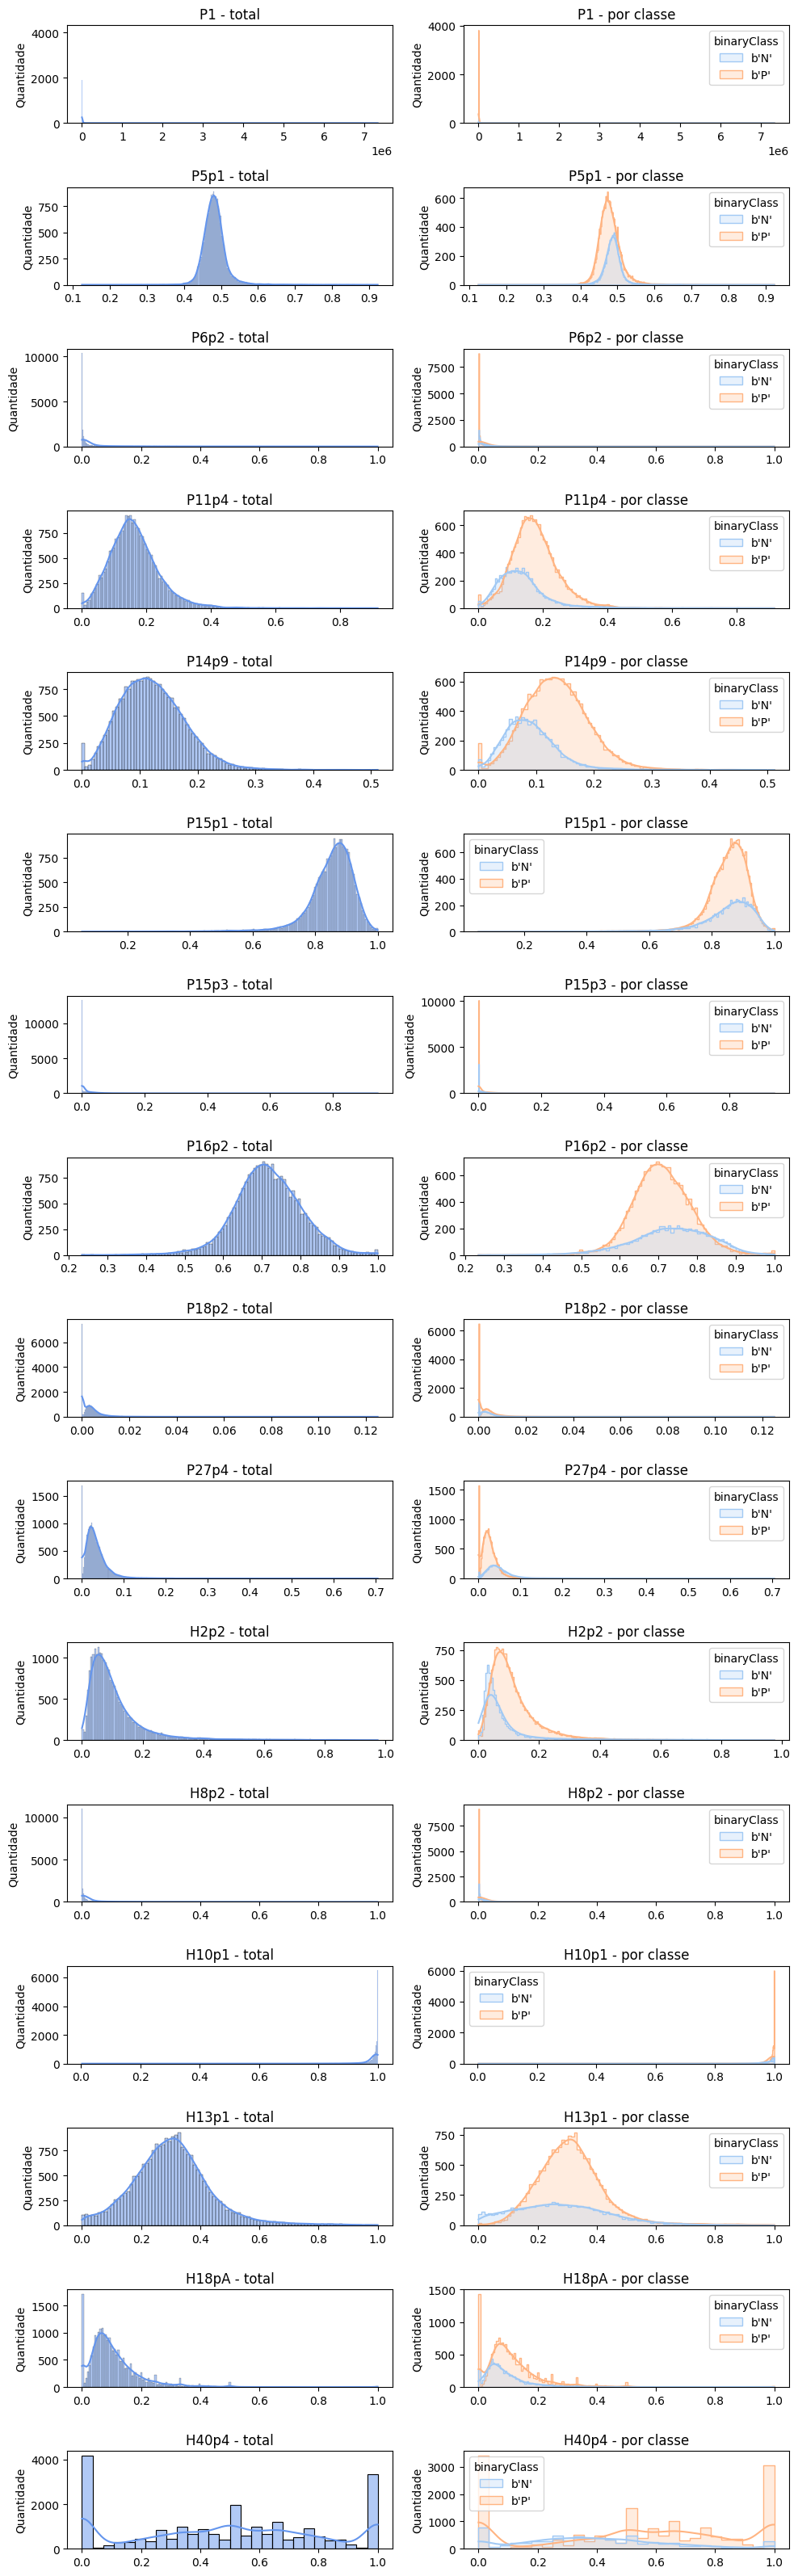

In [ ]:
num_vars = len(continuous_vars)
cols = 2
rows = num_vars

fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
axes = axes.reshape(rows, cols)

for i, col in enumerate(continuous_vars):

    sns.histplot(
        data=df,
        x=col,
        kde=True,
        color='cornflowerblue',
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(f"{col} - total")
    axes[i, 0].set_ylabel("Quantidade")

    sns.histplot(
        data=df,
        x=col,
        hue=categorical_vars[0],
        kde=True,
        palette='pastel',
        element='step',
        stat='count',
        common_norm=False,
        ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"{col} - por classe")
    axes[i, 1].set_ylabel("Quantidade")

    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')

plt.tight_layout()
plt.show()


Com base nos histogramas:

- P1: A distribuição de P1 (número total de pessoas) é altamente assimétrica à direita, com uma grande concentração de valores na extremidade inferior e uma cauda longa que se estende em direção aos valores mais altos. Isso é evidente tanto na distribuição total quanto nas distribuições por classe. A classe 'P' parece ter uma frequência maior de valores mais baixos de P1 em comparação com a classe 'N'.

- P5p1: A distribuição de P5p1 (porcentagem de homens) parece ter uma distribuição relativamente normal, centrada em torno de 0,48, com um pico discreto. As distribuições para ambas as classes são semelhantes em formato, embora possa haver diferenças sutis no pico ou na dispersão.

- P6p2: A distribuição de P6p2 (porcentagem de negros) é fortemente assimétrica em direção a zero, indicando que a maioria das regiões tem uma porcentagem muito baixa de negros. Há uma cauda longa que se estende em direção a porcentagens mais altas. A distribuição para a classe 'P' é ainda mais concentrada em zero do que para a classe 'N'.

- P11p4: A distribuição de P11p4 (percentual de pessoas com mais de 64 anos) apresenta um pico em torno de 0,15-0,20. As distribuições para ambas as classes são relativamente semelhantes em forma, mas pode haver diferenças na altura e na localização exata do pico.

- P14p9: A distribuição de P14p9 (percentual de mulheres viúvas) também é assimétrica à direita, com concentração de valores na extremidade inferior. As distribuições para ambas as classes apresentam um padrão semelhante de assimetria.

- P15p1: A distribuição de P15p1 (percentual de pessoas em domicílios familiares) é assimétrica à esquerda, com concentração de valores na extremidade superior (mais próxima de 1). Ambas as classes apresentam essa assimetria à esquerda.

- P15p3: A distribuição de P15p3 (percentual de pessoas em instituições coletivas) é altamente concentrada em zero, indicando que a maioria das regiões possui um percentual muito baixo de pessoas em instituições coletivas. Semelhante a P6p2, a distribuição para a classe 'P' é mais concentrada em zero do que para a classe 'N'.

- P16p2: A distribuição de P16p2 (porcentagem de domicílios com 2 ou mais membros da família) parece ter uma distribuição relativamente normal, com um pico em torno de 0,7. As distribuições para ambas as classes são semelhantes em formato.

- P18p2: A distribuição de P18p2 (porcentagem de domicílios com 1 ou mais membros menores não familiares) é fortemente assimétrica em direção a zero, indicando que a maioria das regiões possui uma porcentagem muito baixa desses domicílios. Ambas as classes apresentam essa forte assimetria em direção a zero.

- P27p4: A distribuição de P27p4 (porcentagem de domicílios com 2 ou mais membros não familiares) também é assimétrica em direção a zero, com uma cauda longa que se estende para a direita. Ambas as classes apresentam um padrão semelhante de assimetria.

- H2p2: A distribuição de H2p2 (porcentagem de unidades habitacionais vagas) é assimétrica para a direita, com uma concentração de valores na extremidade inferior. Ambas as classes apresentam essa assimetria para a direita.

- H8p2: A distribuição de H8p2 (porcentagem de unidades ocupadas com chefes de família negros) é fortemente assimétrica para zero, semelhante à de P6p2. A distribuição para a classe 'P' é mais concentrada em zero do que para a classe 'N'. Essa forte correlação entre P6p2 e H8p2 também se reflete em seus formatos de histograma semelhantes.

- H10p1: A distribuição de H10p1 (porcentagem de unidades ocupadas com chefes de família não hispânicos) é assimétrica para a esquerda, com uma concentração de valores na extremidade superior (mais próxima de 1). Ambas as classes apresentam essa assimetria para a esquerda.

- H13p1: A distribuição de H13p1 (porcentagem de unidades com 1 a 4 cômodos) parece apresentar distribuição relativamente normal, com um pico em torno de 0,3. As distribuições para ambas as classes apresentam formato semelhante.

- H18pA: A distribuição de H18pA (número médio de pessoas por unidade ocupada pelo proprietário) é assimétrica para a direita, com uma concentração de valores na extremidade inferior. Ambas as classes apresentam essa assimetria para a direita.

- H40p4: A distribuição de H40p4 (porcentagem de unidades vagas à venda há mais de 6 meses) parece apresentar distribuição relativamente uniforme entre 0 e 1, com um ligeiro pico em torno de 0,5. As distribuições para ambas as classes apresentam formato semelhante.

De modo geral, muitas das variáveis apresentam distribuições assimétricas, particularmente aquelas que representam porcentagens de determinados dados demográficos ou características habitacionais. Para algumas variáveis (P6p2, P15p3, H8p2), há diferenças perceptíveis nas distribuições entre as duas classes, sugerindo que essas características podem ser mais importantes para distinguir entre as classes.

---

### Detecção de Outliers e Valores Fora da Escala

Para definir o número de outliers para cada variável contínua, usamos o método z-score. Valores com um z-score maior que 3 são identificados como outliers. Abaixo mostramos o número de outliers detectados para cada atributo contínuo.

In [ ]:
outlier_info = pd.DataFrame()
for col in continuous_vars:
    z_scores = zscore(df[col].dropna())
    outliers = (abs(z_scores) > 3).sum()
    outlier_info.loc[col, 'Outliers (>3σ)'] = outliers

print("Número de outliers por variável:\n")
outlier_info

Número de outliers por variável:



Outliers (>3σ)
P1               73.0
P5p1            315.0
P6p2            715.0
P11p4           231.0
P14p9           154.0
P15p1           393.0
P15p3           413.0
P16p2           209.0
P18p2           330.0
P27p4           334.0
H2p2            520.0
H8p2            659.0
H10p1           516.0
H13p1           292.0
H18pA           411.0
H40p4             0.0

Ademais, podemos gerar boxplots para cada variável contínua. Criamos dois boxplots por variável: um mostrando a distribuição geral e outro mostrando a distribuição dividida pelas categorias "binaryClass". Isso ajuda a visualizar a distribuição, a mediana, os quartis e os potenciais valores discrepantes para cada variável e como eles diferem entre as duas classes.

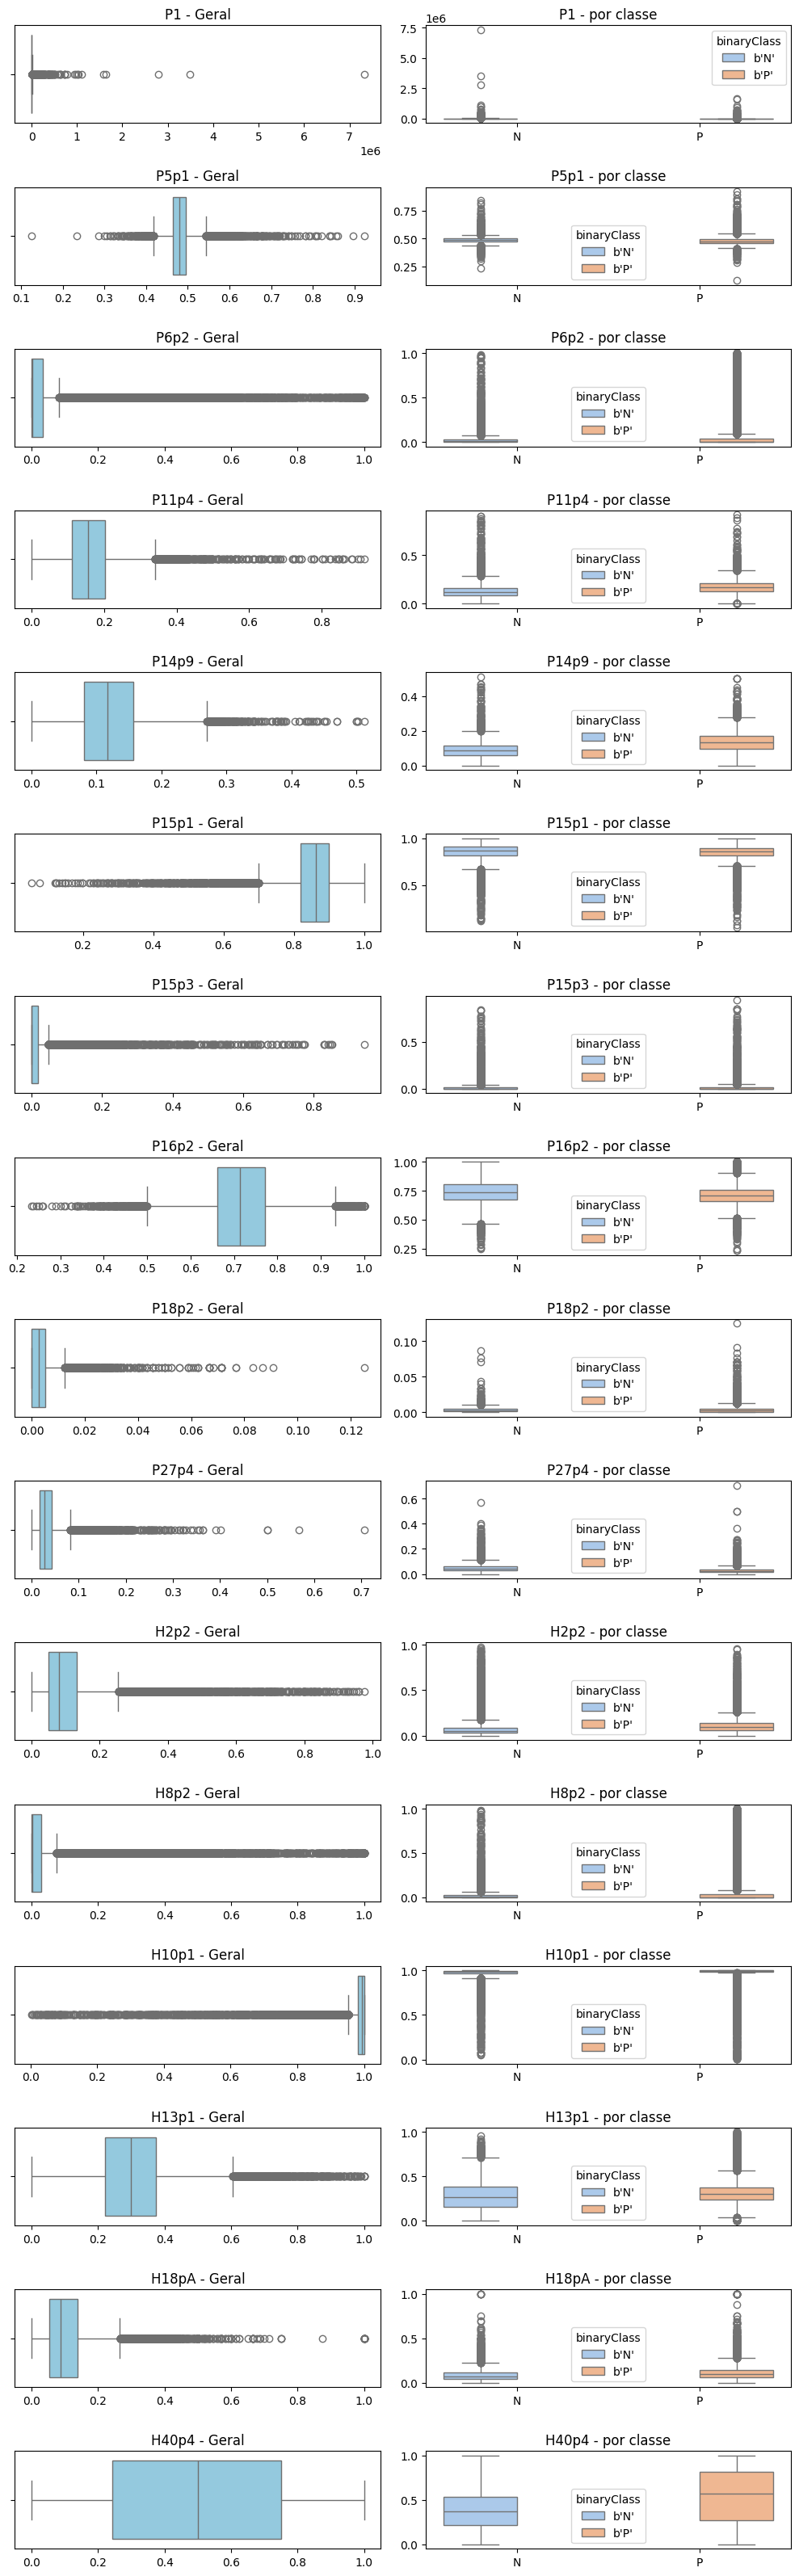

In [ ]:
num_vars = len(continuous_vars)
cols = 2
rows = num_vars

fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
axes = axes.reshape(rows, cols)

for i, col in enumerate(continuous_vars):
    # Boxplot geral (sem classe)
    sns.boxplot(data=df, x=col, color='skyblue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} - Geral')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')

    # Boxplot por classe (com hue)
    sns.boxplot(data=df, x=categorical_vars[0], y=col, hue=categorical_vars[0], palette='pastel', dodge=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} - por classe')
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')

plt.tight_layout()
plt.show()

Com base nos boxplots:

- P1: O boxplot para P1 mostra uma distribuição altamente assimétrica, com um grande número de valores discrepantes na extremidade superior. A mediana é baixa e o box se concentra nos valores mais baixos. Quando divididas por classe, ambas as classes mostram um padrão semelhante de assimetria à direita e valores discrepantes, mas a classe "P" parece ter uma mediana ligeiramente menor e menos dispersão em comparação com a classe "N".

- P5p1: O boxplot para P5p1 mostra uma distribuição relativamente simétrica, com alguns valores discrepantes em ambas as extremidades. Quando divididas por classe, os boxplots para ambas as classes são bastante semelhantes, sugerindo que a porcentagem de homens não diferencia fortemente entre as duas classes.

- P6p2: O boxplot para P6p2 é altamente assimétrico em direção a zero, com muitos valores discrepantes em valores mais altos. A maioria dos dados está agrupada perto do mínimo. O boxplot para a classe "P" é ainda mais concentrado em zero do que para a classe "N", indicando que regiões com maior percentual de negros têm maior probabilidade de pertencer à classe "N".

- P11p4: O boxplot para P11p4 mostra uma distribuição com leve assimetria à direita e alguns valores discrepantes. Os boxplots para ambas as classes são relativamente semelhantes, sugerindo que a porcentagem de pessoas com mais de 64 anos tem uma distribuição semelhante em ambas as classes.

- P14p9: O boxplot para P14p9 é assimétrico à direita com valores discrepantes. Os boxplots para ambas as classes mostram um padrão semelhante de assimetria à direita, com mediana e quartis próximos para ambas as classes.

- P15p1: O boxplot para P15p1 é assimétrico à esquerda, com a caixa e a mediana mais próximas de 1. Há valores discrepantes na extremidade inferior. Os boxplots para ambas as classes são semelhantes em forma e posição, sugerindo que a porcentagem de pessoas em domicílios familiares é distribuída de forma semelhante entre ambas as classes.

- P15p3: O boxplot para P15p3 é altamente concentrado em zero, com um número significativo de outliers em valores mais altos. Isso indica que a maioria das regiões tem uma porcentagem muito baixa de pessoas em instituições coletivas. O boxplot para a classe 'P' é mais concentrado em zero do que para a classe 'N', sugerindo que regiões com maior porcentagem de pessoas em instituições coletivas têm maior probabilidade de estar na classe 'N'.

- P16p2: O boxplot para P16p2 mostra uma distribuição relativamente simétrica com alguns outliers. Os boxplots para ambas as classes são muito semelhantes, sugerindo que a porcentagem de domicílios com 2 ou mais membros da família é distribuída de forma semelhante entre ambas as classes.

- P18p2: O boxplot para P18p2 é fortemente assimétrico em direção a zero, com muitos outliers em valores mais altos. Ambas as classes apresentam essa forte assimetria em direção a zero, indicando que domicílios com menores não familiares são raros em ambas as classes.

- P27p4: O boxplot para P27p4 é assimétrico em direção a zero com valores discrepantes. Ambas as classes apresentam um padrão semelhante de assimetria, com a maioria dos valores concentrados na extremidade inferior.

- H2p2: O boxplot para H2p2 é assimétrico à direita com valores discrepantes. Ambas as classes apresentam um padrão semelhante de assimetria à direita, com a mediana e os quartis próximos para ambas as classes.

- H8p2: O boxplot para H8p2 é fortemente assimétrico em direção a zero, semelhante ao P6p2, com muitos valores discrepantes em valores mais altos. O boxplot para a classe 'P' é mais concentrado em zero do que para a classe 'N', reforçando a observação dos histogramas de que regiões com maior porcentagem de chefes de família negros têm maior probabilidade de estar na classe 'N'.

- H10p1: O boxplot para H10p1 é assimétrico à esquerda, com a caixa e a mediana mais próximas de 1. Há valores discrepantes na extremidade inferior. Os boxplots para ambas as classes são semelhantes em forma e posição, sugerindo que a porcentagem de unidades ocupadas por chefes de família não hispânicos é distribuída de forma semelhante entre ambas as classes.

- H13p1: O boxplot para H13p1 parece relativamente simétrico, com alguns valores discrepantes. Os boxplots para ambas as classes são bastante semelhantes, sugerindo que a porcentagem de unidades com 1 a 4 cômodos é distribuída de forma semelhante entre ambas as classes.

- H18pA: O boxplot para H18pA é assimétrico à direita, com valores discrepantes. Ambas as classes apresentam um padrão semelhante de assimetria à direita, com a mediana e os quartis próximos para ambas as classes.

- H40p4: O boxplot para H40p4 parece relativamente simétrico, com alguns valores discrepantes. Os boxplots para ambas as classes são bastante semelhantes, sugerindo que a porcentagem de unidades vagas à venda há mais de 6 meses é distribuída de forma semelhante entre ambas as classes.

Em resumo, os boxplots confirmam visualmente a assimetria observada nos histogramas para muitas variáveis e destacam a presença de outliers. Para variáveis como P6p2, P15p3 e H8p2, os boxplots mostram claramente diferenças na distribuição entre as duas classes, com a classe "N" apresentando uma dispersão mais ampla e valores de mediana/quartil mais altos em comparação com a classe "P". Isso reforça ainda mais a ideia de que essas características podem ser importantes para a distinção entre as classes.

---

### Distribuição na variável-alvo:

Abaixo visualizamos a distribuição da variável-alvo, "binaryClass", usando um gráfico de contagem e um gráfico de pizza. O gráfico de contagem mostra a frequência de cada classe, e o gráfico de pizza mostra a distribuição percentual.

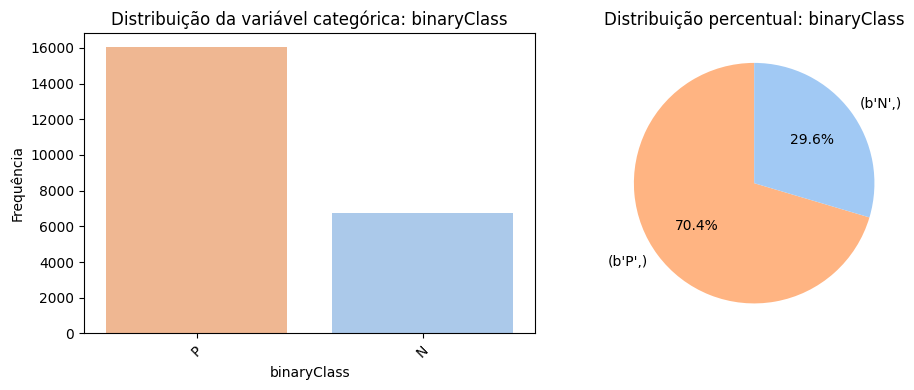

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=df, x=categorical_vars[0], hue=categorical_vars[0], palette='pastel', order=df[categorical_vars[0]].value_counts().index, legend=False, ax=ax[0])
ax[0].set_title(f'Distribuição da variável categórica: {categorical_vars[0]}')
ax[0].set_xlabel(categorical_vars[0])
ax[0].set_ylabel('Frequência')
ax[0].tick_params(axis='x', rotation=45)

value_counts = df[categorical_vars].value_counts(dropna=False)
percentages = value_counts / value_counts.sum() * 100

ax[1].pie(
    percentages,
    labels=percentages.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel')[:len(percentages)][::-1],
)
ax[1].set_title(f'Distribuição percentual: {categorical_vars[0]}')

plt.tight_layout()
plt.show()

Vemos acima que há um desbalanceamento entre as classes, o que pode impactar significativamente o desempenho dos modelos de aprendizagem de máquina, em especial para a classe minoritária (Classe $N$, com $29.6\%$).

Visando equilibrar a distribuição das classes, podemos aplicar random over-sampling da classe $N$ ou random under-sampling da classe $P$ ou SMOTE.

---

### Correlação entre as 16 features:

Para verificar e visualiza a matriz de correlação entre as variáveis contínuas, usamos o método `corr()` e `seaborn.heatmap`. As anotações no mapa de calor mostram os coeficientes de correlação par-a-par, ajudando a identificar características altamente correlacionadas.

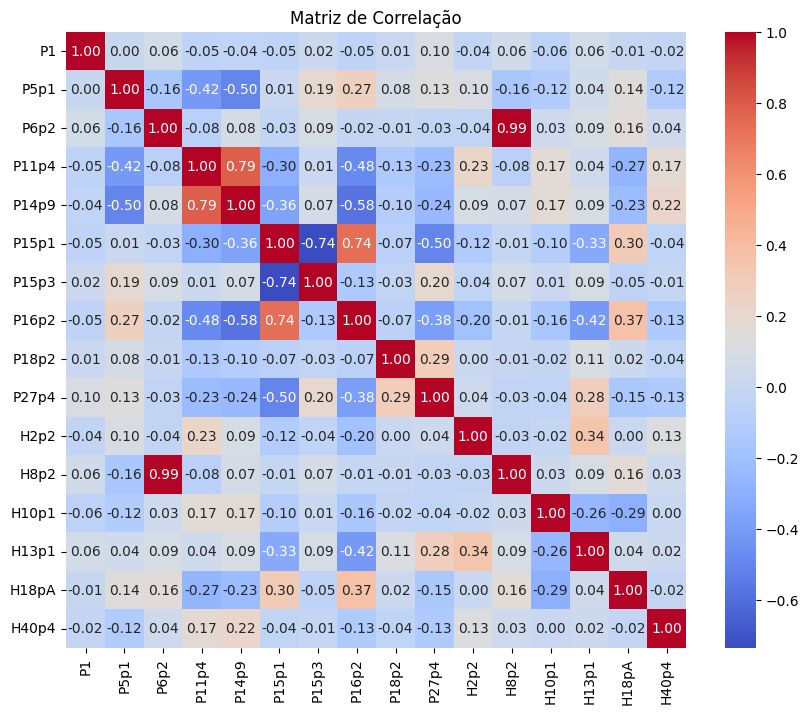

In [ ]:
corr = df[continuous_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

Diante da matriz de correlação acima, temos apenas uma correlação (quer positiva, quer negativa) acima de $0.8$:

- Correlação de $0.99$ entre $P6p2$ e $H8p2$.

A pouca quantidade de correlação indica que não precisamos nos preocupar em remover ou combinar features devido à multicolinearidade.

---

### Dispersão entre as 16 features:

Uma grade de diagramas de dispersão para cada par de variáveis contínuas está mostrado abaixo. Ele fornece uma visão geral das relações entre todos os pares de características contínuas.

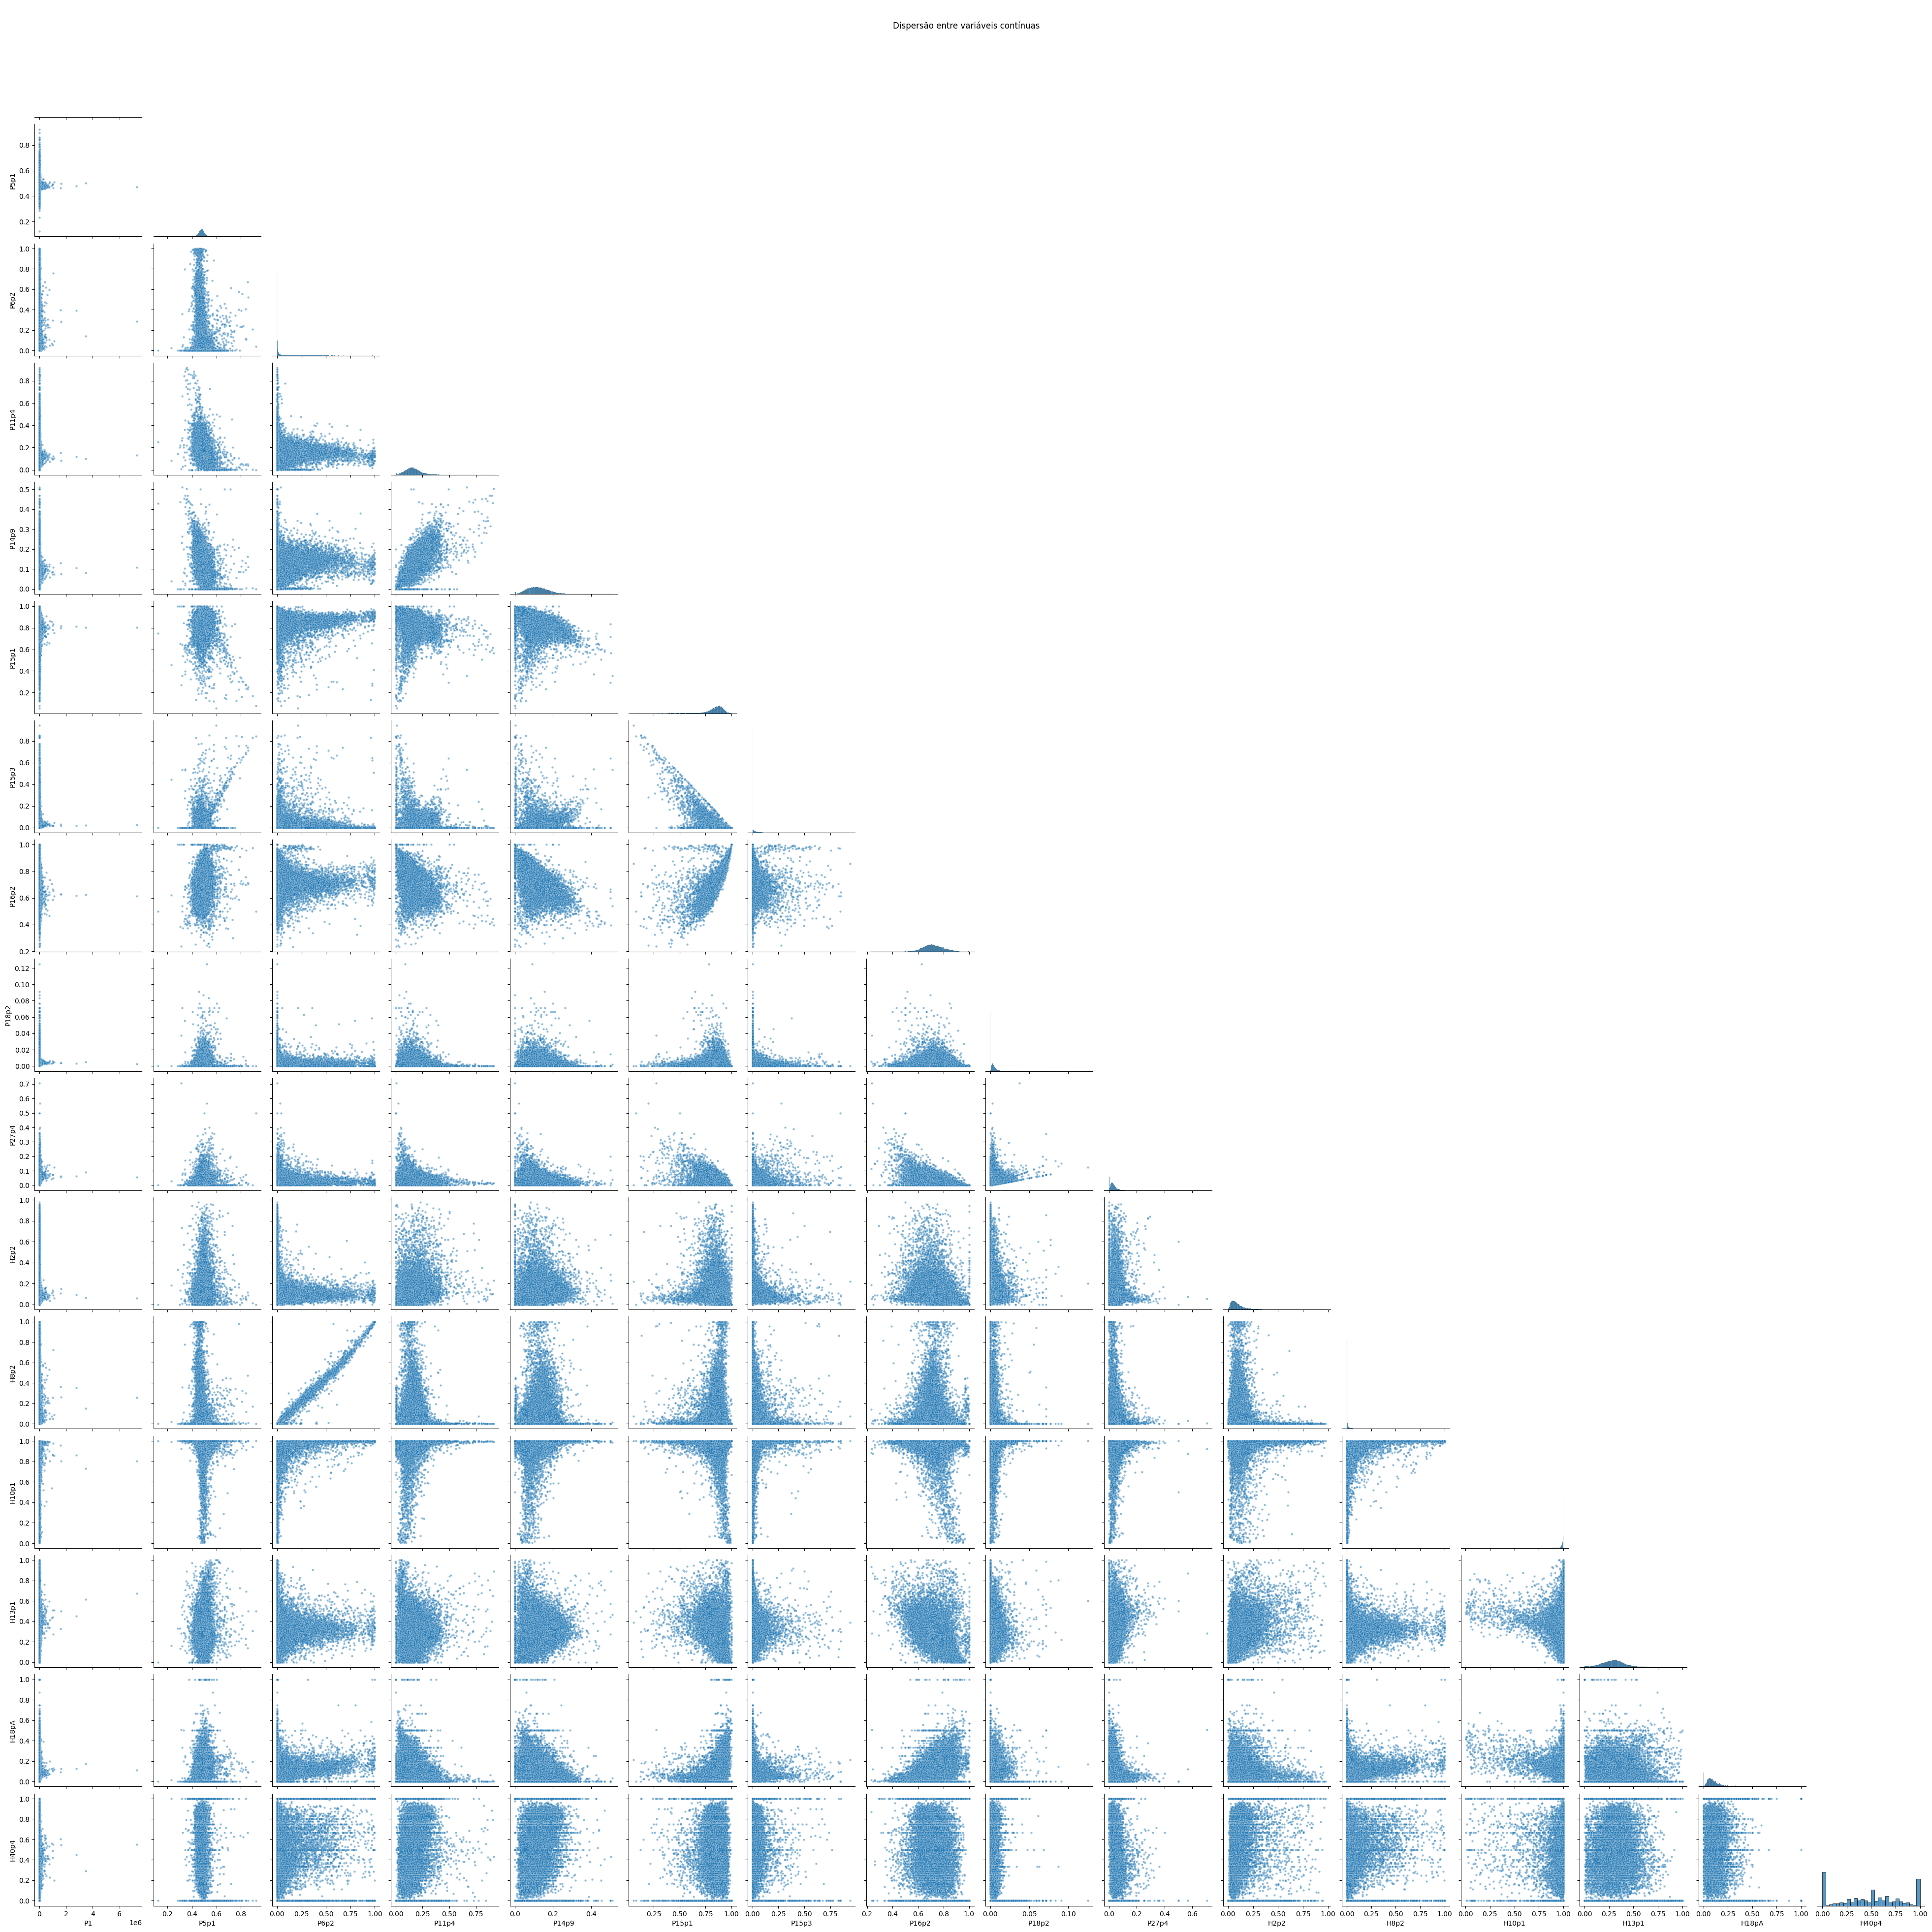

In [ ]:
sns.pairplot(df[continuous_vars], corner=True, plot_kws={'alpha': 0.5, 's': 10})
plt.suptitle("Dispersão entre variáveis contínuas")
plt.show()

Abaixo temos uma seleção de alguns gráficos de dispersão, com pontos coloridos de acordo com sua 'binaryClass'.

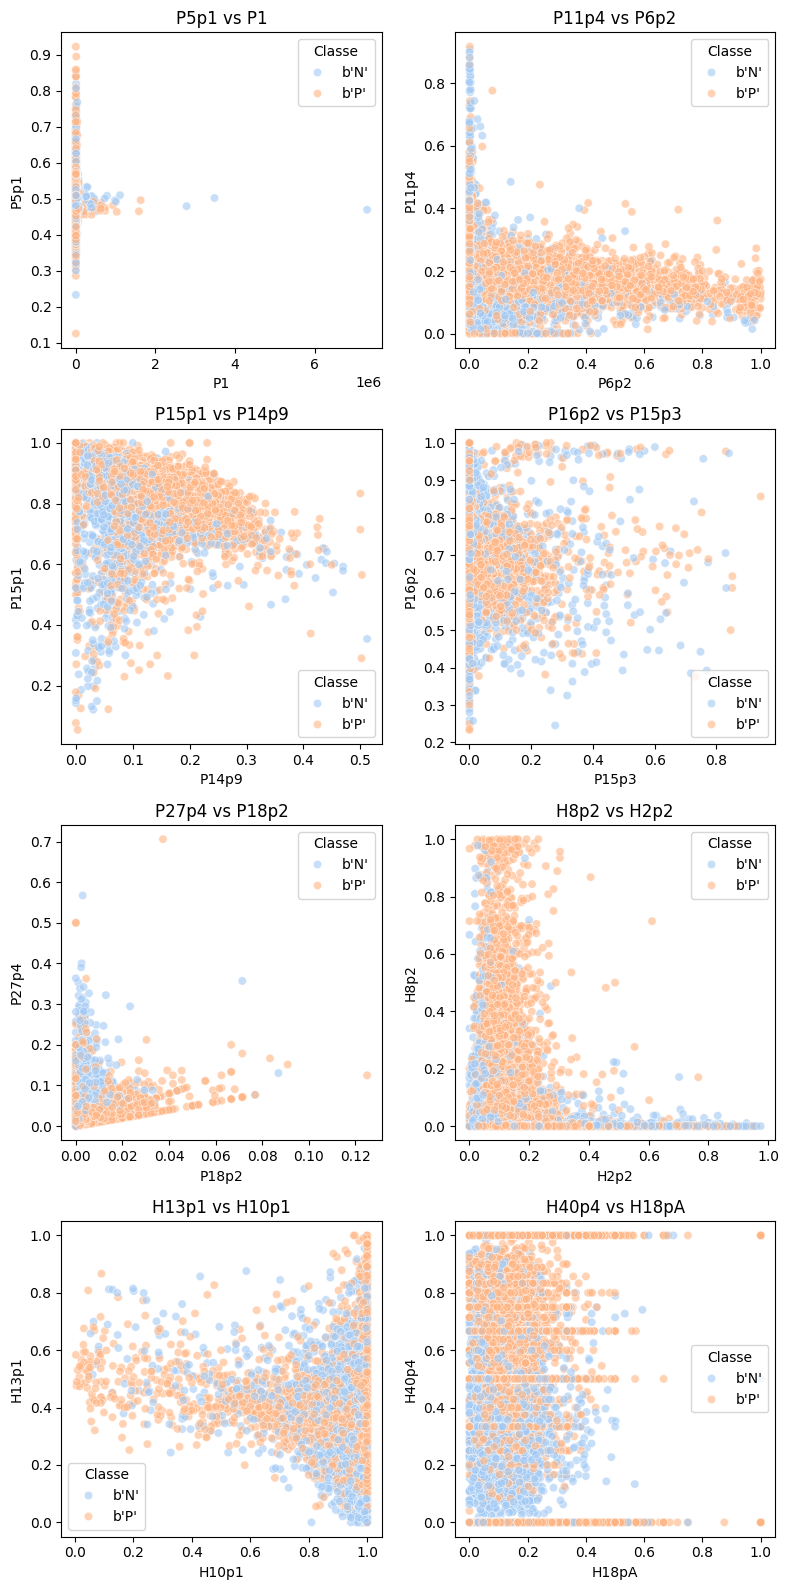

In [ ]:
pairs = [(continuous_vars[i], continuous_vars[i+1]) for i in range(0, len(continuous_vars)-1, 2)]

cols = 2
rows = math.ceil(len(pairs) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

axes = axes.flatten()
for i, (x_var, y_var) in enumerate(pairs):
    sns.scatterplot(data=df, x=x_var, y=y_var, hue=categorical_vars[0], ax=axes[i], palette='pastel', alpha=0.6)
    axes[i].set_title(f'{y_var} vs {x_var}')
    axes[i].legend(title='Classe')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

---

## Preparação dos Dados

### Divisão de subsets utilizando estratificação

Antes de mais nada, é importante dividir o conjunto de dados total em subconjuntos menores para treino, teste e validação. Como iremos também fazer a preparação dos dados, essa etapa preliminar é importante para garantir que não haja vazamento de dados e que o conjunto de testes seja fiel aos dados originais.

- Conjunto de Treinamento: O conjunto de treinamento é utilizado para ensinar o modelo. Ele é usado para ajustar os parâmetros do modelo e permitir que ele aprenda padrões a partir dos dados. No nosso caso, epresenta 70% do total de dados.

- Conjunto de Validação: O conjunto de validação é usado durante o treinamento para monitorar o desempenho do modelo e ajustar hiperparâmetros, como a taxa de aprendizado ou o número de camadas. Ele ajuda a evitar o overfitting. O conjunto de validação representa 15% dos dados.

- Conjunto de Teste: Após o treinamento e validação, o conjunto de teste é utilizado para avaliar o desempenho final do modelo. Ele deve ser totalmente separado dos dados de treinamento e validação para garantir que o modelo não tenha "visto" os dados de teste durante o processo de treinamento. O conjunto de teste também representa 15% dos dados.

Essa divisão ajuda a garantir que o modelo seja treinado de forma robusta e que sua avaliação seja realista, refletindo o desempenho em dados não vistos. Além disso, práticas como a validação cruzada podem ser usadas para obter uma avaliação mais precisa, dividindo os dados em várias partes e treinando e testando o modelo em diferentes combinações dessas divisões.

In [ ]:
X = df.drop(columns=['binaryClass'])
y = df['binaryClass']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=random_seed, stratify=y_val_test)

print("Tamanho do conjunto de treinamento:", X_train.shape)
print("Tamanho do conjunto de validação:", X_val.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

Tamanho do conjunto de treinamento: (15948, 16)
Tamanho do conjunto de validação: (3417, 16)
Tamanho do conjunto de teste: (3418, 16)


---

### Codificação de Variáveis

Como visto na seção acima, a única variável que necessita modificação de tipo é a $binaryClass$, que originalmente está representado como string (object).

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print("Classes originais:", label_encoder.classes_)
print("Classes codificadas:", label_encoder.transform(label_encoder.classes_))

Classes originais: [b'N' b'P']
Classes codificadas: [0 1]


---

### Reamostragem no conjunto de treinamento

Para equilibrar a distribuição das classes, vamos aplicar o SMOTE no conjunto de treinamento.

In [ ]:
smote = SMOTE(random_state=random_seed)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
print("Distribuição da classe no conjunto de treinamento:\n", pd.Series(y_train).value_counts())

Distribuição da classe no conjunto de treinamento:
 0    11228
1    11228
Name: count, dtype: int64


---

### Remoção de Outliers

Para remover outliers dos dados de treinamento, aplicamos o método z-score com um threshold de 3. Isso removerá as linhas onde qualquer variável contínua tem um z-score absoluto maior que 3.

In [ ]:
z_scores_train = zscore(X_train)
abs_z_scores_train = abs(z_scores_train)
filtered_entries = (abs_z_scores_train < 3).all(axis=1)

X_train_filtered = X_train[filtered_entries]
y_train_filtered = y_train[filtered_entries]

print(f"Tamanho original do conjunto de treinamento: {X_train.shape}")
print(f"Tamanho do conjunto de treinamento após remoção de outliers: {X_train_filtered.shape}")

Tamanho original do conjunto de treinamento: (22456, 16)
Tamanho do conjunto de treinamento após remoção de outliers: (18983, 16)


A fim de avaliarmos a performance dos modelos com diferentes versões de dados, iremos manter versões intermediárias do datset.

---

### Remoção de variáveis com alta correlação

Com base na matriz de correlação, identificamos que as variáveis 'P6p2' e 'H8p2' possuem uma alta correlação (0.99). Para evitar multicolinearidade, vamos remover uma delas. Escolhemos remover a variável 'H8p2'.

Vamos criar novas versões dos conjuntos de dados de treino, validação e teste, tanto para os dados originais quanto para os dados filtrados (sem outliers), removendo a variável 'H8p2'.

In [ ]:
vars_to_remove = ['H8p2']

X_train_no_corr = X_train.drop(columns=vars_to_remove)

X_train_filtered_no_corr = X_train_filtered.drop(columns=vars_to_remove)

print("Tamanho do conjunto de treinamento original com correlação:", X_train.shape)
print("Tamanho do conjunto de treinamento original sem correlação:", X_train_no_corr.shape)
print("Tamanho do conjunto de treinamento filtrado com correlação:", X_train_filtered.shape)
print("Tamanho do conjunto de treinamento filtrado sem correlação:", X_train_filtered_no_corr.shape)

X_val_no_corr = X_val.drop(columns=vars_to_remove)
X_val_no_corr = X_val.drop(columns=vars_to_remove)

X_test_no_corr = X_test.drop(columns=vars_to_remove)
X_test_no_corr = X_test.drop(columns=vars_to_remove)

Tamanho do conjunto de treinamento original com correlação: (22456, 16)
Tamanho do conjunto de treinamento original sem correlação: (22456, 15)
Tamanho do conjunto de treinamento filtrado com correlação: (18983, 16)
Tamanho do conjunto de treinamento filtrado sem correlação: (18983, 15)


---

### Normalizando os subconjuntos

Vamos normalizar as variáveis contínuas nos conjuntos de treinamento, validação e teste usando o `StandardScaler` do scikit-learn. É importante ajustar o scaler apenas nos dados de treinamento para evitar vazamento de dados. Vamos aplicar a normalização em todas as quatro versões dos nossos conjuntos de dados:

1. Conjuntos originais (`X_train`, `X_val`, `X_test`)
2. Conjuntos filtrados (sem outliers) (`X_train_filtered`, `X_val`, `X_test`)
3. Conjuntos originais sem variáveis correlacionadas (`X_train_no_corr`, `X_val_no_corr`, `X_test_no_corr`)
4. Conjuntos filtrados (sem outliers) sem variáveis correlacionadas (`X_train_filtered_no_corr`, `X_val_filtered_no_corr`, `X_test_filtered_no_corr`)

In [ ]:
scaler_original = MinMaxScaler()
X_train_scaled = scaler_original.fit_transform(X_train)

X_val_scaled = scaler_original.transform(X_val)
X_test_scaled = scaler_original.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


scaler_filtered = MinMaxScaler()
X_train_filtered_scaled = scaler_filtered.fit_transform(X_train_filtered)

X_val_filtered_scaled = scaler_filtered.transform(X_val)
X_test_filtered_scaled = scaler_filtered.transform(X_test)

X_train_filtered_scaled = pd.DataFrame(X_train_filtered_scaled, columns=X_train_filtered.columns, index=X_train_filtered.index)
X_val_filtered_scaled = pd.DataFrame(X_val_filtered_scaled, columns=X_val.columns, index=X_val.index)
X_test_filtered_scaled = pd.DataFrame(X_test_filtered_scaled, columns=X_test.columns, index=X_test.index)


scaler_no_corr = MinMaxScaler()
X_train_no_corr_scaled = scaler_no_corr.fit_transform(X_train_no_corr)

X_val_no_corr_scaled = scaler_no_corr.transform(X_val_no_corr)
X_test_no_corr_scaled = scaler_no_corr.transform(X_test_no_corr)

X_train_no_corr_scaled = pd.DataFrame(X_train_no_corr_scaled, columns=X_train_no_corr.columns, index=X_train_no_corr.index)
X_val_no_corr_scaled = pd.DataFrame(X_val_no_corr_scaled, columns=X_val_no_corr.columns, index=X_val_no_corr.index)
X_test_no_corr_scaled = pd.DataFrame(X_test_no_corr_scaled, columns=X_test_no_corr.columns, index=X_test_no_corr.index)


scaler_filtered_no_corr = MinMaxScaler()
X_train_filtered_no_corr_scaled = scaler_filtered_no_corr.fit_transform(X_train_filtered_no_corr)
X_val_filtered_no_corr_scaled = scaler_filtered_no_corr.transform(X_val_no_corr)
X_test_filtered_no_corr_scaled = scaler_filtered_no_corr.transform(X_test_no_corr)

X_train_filtered_no_corr_scaled = pd.DataFrame(X_train_filtered_no_corr_scaled, columns=X_train_filtered_no_corr.columns, index=X_train_filtered_no_corr.index)
X_val_filtered_no_corr_scaled = pd.DataFrame(X_val_filtered_no_corr_scaled, columns=X_val_no_corr.columns, index=X_val_no_corr.index)
X_test_filtered_no_corr_scaled = pd.DataFrame(X_test_filtered_no_corr_scaled, columns=X_test_no_corr.columns, index=X_test_no_corr.index)

In [ ]:
X_train_scaled.head()

P1      P5p1      P6p2     P11p4     P14p9     P15p1     P15p3  \
0  0.000355  0.485319  0.005387  0.232388  0.126039  0.886097  0.000000   
1  0.000167  0.546893  0.004078  0.128940  0.172172  0.822353  0.025940   
2  0.000053  0.479948  0.005102  0.200243  0.236801  0.910996  0.000000   
3  0.004145  0.441598  0.071720  0.160440  0.245331  0.803519  0.048404   
4  0.000028  0.418602  0.000000  0.129787  0.218940  0.914413  0.000000   

      P16p2     P18p2     P27p4      H2p2      H8p2     H10p1     H13p1  \
0  0.733221  0.020440  0.043450  0.106701  0.005111  0.994019  0.104740   
1  0.585439  0.050952  0.063177  0.379503  0.004246  0.848764  0.739541   
2  0.744944  0.000000  0.038040  0.332907  0.000000  1.000000  0.337900   
3  0.594606  0.024008  0.049492  0.084120  0.066105  0.988960  0.398621   
4  0.720436  0.000000  0.018892  0.133218  0.000000  0.986623  0.383721   

      H18pA     H40p4  
0  0.042683  0.363636  
1  0.129412  1.000000  
2  0.129032  0.000000  
3  0.059173  0.453125  
4  0.222222  1.000000

In [ ]:
X_train_scaled.describe().T

count      mean       std  min       25%       50%       75%  max
P1     22456.0  0.001376  0.010221  0.0  0.000079  0.000272  0.000900  1.0
P5p1   22456.0  0.465803  0.038619  0.0  0.445848  0.464772  0.482173  1.0
P6p2   22456.0  0.056320  0.133026  0.0  0.000321  0.006009  0.034558  1.0
P11p4  22456.0  0.170463  0.087644  0.0  0.113518  0.158371  0.211464  1.0
P14p9  22456.0  0.219855  0.106139  0.0  0.144606  0.206129  0.281772  1.0
P15p1  22456.0  0.842538  0.082658  0.0  0.809675  0.856538  0.894069  1.0
P15p3  22456.0  0.021757  0.058486  0.0  0.000000  0.000777  0.020316  1.0
P16p2  22456.0  0.635048  0.114189  0.0  0.563181  0.634963  0.710393  1.0
P18p2  22456.0  0.028939  0.037158  0.0  0.000000  0.022872  0.039832  1.0
P27p4  22456.0  0.053633  0.042299  0.0  0.027784  0.045946  0.069940  1.0
H2p2   22456.0  0.111257  0.113137  0.0  0.046519  0.076894  0.129759  1.0
H8p2   22456.0  0.050558  0.123144  0.0  0.000000  0.004859  0.031060  1.0
H10p1  22456.0  0.963252  0.095861  0.0  0.973560  0.991199  0.997532  1.0
H13p1  22456.0  0.298341  0.134594  0.0  0.210808  0.292868  0.372738  1.0
H18pA  22456.0  0.102889  0.084331  0.0  0.052548  0.083522  0.130719  1.0
H40p4  22456.0  0.461789  0.304842  0.0  0.250000  0.454546  0.666667  1.0

---

## Seleção de Modelos

### Rede Neural MLP (Multilayer Perceptron)

O MLP (Multi-Layer Perceptron) é uma rede neural artificial de aprendizado supervisionado usada para classificação. Ela é composta por camadas de neurônios (perceptrons) totalmente conectadas, capazes de aprender representações complexas por meio de funções de ativação não lineares e ajuste de pesos via retropropagação. O MLPClassifier do sklearn oferece uma implementação simples e eficiente para problemas de classificação multiclasse, sendo especialmente útil quando os dados têm padrões não lineares. Requer ajuste cuidadoso dos hiperparâmetros e pode demandar mais tempo de treinamento do que métodos mais simples.

In [ ]:
mlp = MLPClassifier()

Definindo o espaço de parâmetros para o MLP `sklearn.neural_network.MLPClassifier`:

* **hidden_layer_sizes:** Define a arquitetura da rede neural especificando o número de neurônios em cada camada oculta. Uma tupla como (100,) cria uma única camada oculta com 100 neurônios, enquanto (64, 32) cria duas camadas com 64 e 32 neurônios respectivamente. Redes mais profundas (múltiplas camadas) podem capturar padrões complexos, mas requerem mais dados e tempo de treinamento. Camadas muito largas podem levar ao overfitting, enquanto camadas muito pequenas podem não ter capacidade suficiente para aprender os padrões dos dados.

* **activation:** Função de ativação aplicada aos neurônios das camadas ocultas, determinando como a informação é transformada entre camadas. "relu" (Rectified Linear Unit) é geralmente a escolha padrão por sua eficiência computacional e capacidade de mitigar o problema do gradiente desvanecente. "tanh" (tangente hiperbólica) produz saídas entre -1 e 1, sendo útil quando os dados têm valores negativos. "logistic" (sigmóide) produz saídas entre 0 e 1, mas pode sofrer com gradientes desvanecentes em redes profundas. A escolha impacta diretamente a capacidade de aprendizado e velocidade de convergência.

* **solver:** Algoritmo de otimização responsável por ajustar os pesos da rede durante o treinamento. "adam" é um otimizador adaptativo que combina momentum com taxas de aprendizado individuais para cada parâmetro, sendo eficiente e robusto para a maioria dos problemas. "sgd" (Stochastic Gradient Descent) é mais simples e pode ser preferível para conjuntos de dados grandes, especialmente quando combinado com momentum. "lbfgs" é eficiente para pequenos conjuntos de dados, mas consome mais memória. A escolha do solver afeta significativamente a velocidade e qualidade da convergência.

* **alpha:** Parâmetro de regularização L2 que adiciona uma penalidade proporcional à magnitude dos pesos, controlando a complexidade do modelo. Valores baixos (0.0001) aplicam pouca regularização, permitindo que o modelo se ajuste mais aos dados de treinamento, mas aumentando o risco de overfitting. Valores altos (0.01 ou mais) impõem maior regularização, criando modelos mais simples e generalizáveis, mas que podem sofrer de underfitting. O ajuste adequado é crucial para equilibrar bias e variância.

* **learning_rate:** Estratégia para ajustar a taxa de aprendizado durante o treinamento. "constant" mantém a taxa fixa durante todo o processo, proporcionando comportamento previsível mas podendo ser subótimo se a taxa inicial não for adequada. "adaptive" reduz a taxa quando a perda para de diminuir, ajudando a convergência fina e evitando oscilações próximo ao mínimo. "invscaling" diminui gradualmente a taxa seguindo uma programação específica. A estratégia adequada pode acelerar significativamente a convergência e melhorar a qualidade da solução final.

* **max_iter:** Número máximo de iterações (épocas) que o algoritmo executará durante o treinamento. Valores baixos podem resultar em convergência incompleta, especialmente para problemas complexos ou taxas de aprendizado baixas. Valores muito altos aumentam o tempo computacional desnecessariamente e podem levar ao overfitting se não houver critérios de parada adequados. O valor ideal depende da complexidade dos dados, arquitetura da rede e solver utilizado.

* **random_state:** Semente para o gerador de números aleatórios, garantindo reprodutibilidade dos resultados. Como o MLP inicializa os pesos aleatoriamente e alguns solvers utilizam amostragem estocástica, definir este parâmetro é essencial para obter resultados consistentes entre execuções. Importante para comparações justas entre diferentes configurações de hiperparâmetros e para permitir a replicação de experimentos.

In [ ]:
MLP_parameters = {
    'hidden_layer_sizes': [(16,), (32,), (64,), (32, 16,), (64, 32,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000],
    'random_state': [random_seed]
}

### Comitê de Redes Neurais Artificiais

O Comitê de Redes Neurais com BaggingClassifier é uma técnica de aprendizado em conjunto (ensemble) que combina várias redes neurais treinadas em subconjuntos aleatórios do conjunto de dados. Cada rede neural aprende de maneira independente e as previsões são agregadas (por votação, no caso de classificação) para melhorar a robustez e reduzir o overfitting. Essa abordagem aumenta a estabilidade das redes neurais individuais e costuma apresentar melhor desempenho do que uma única rede, especialmente em dados ruidosos ou complexos.

In [ ]:
ensemble_bagging = BaggingClassifier()

Definindo o espaço de parâmetros para o Comitê de Redes Neurais com BaggingClassifier `sklearn.ensemble.BaggingClassifier`:

* **n_estimators:** Define o número de redes neurais (modelos base) que compõem o comitê de classificadores. Um número baixo de estimadores (como 5) pode não capturar adequadamente a diversidade necessária para reduzir a variância, limitando os benefícios do ensemble. Valores moderados (10-20) geralmente oferecem um bom equilíbrio entre performance e custo computacional, aproveitando a sabedoria coletiva sem overhead excessivo. Números muito altos podem levar a retornos decrescentes e aumento significativo do tempo de treinamento e predição, especialmente considerando que cada estimador é uma rede neural completa.

* **max_samples:** Controla a proporção ou número absoluto de amostras do conjunto de treinamento utilizadas para treinar cada rede neural individual. Valores menores (0.5) criam maior diversidade entre os modelos, pois cada um vê apenas metade dos dados, potencializando a redução da variância através da combinação de perspectivas diferentes. Valores maiores (0.8-1.0) permitem que cada modelo tenha acesso a mais informação, potencialmente melhorando a performance individual de cada estimador. A escolha ideal depende do tamanho do dataset e da complexidade do problema.

* **max_features:** Especifica a proporção ou número de características (features) disponibilizadas para cada estimador durante o treinamento. Reduzir este valor (0.5) introduz diversidade dimensional, forçando cada rede neural a aprender padrões diferentes baseados em subconjuntos distintos de características, o que pode ser especialmente útil em datasets com alta dimensionalidade ou características correlacionadas. Usar todas as características (1.0) maximiza a informação disponível para cada modelo individual, mas pode reduzir a diversidade do ensemble.

* **bootstrap:** Determina se a amostragem das instâncias de treinamento é feita com reposição (bootstrap verdadeiro). Quando ativado (True), permite que a mesma amostra apareça múltiplas vezes no conjunto de treinamento de um estimador, criando variações naturais mesmo quando max_samples=1.0. Esta abordagem clássica do bagging introduz aleatoriedade que contribui para a diversidade do ensemble. Quando desativado (False), realiza amostragem sem reposição, garantindo que cada amostra apareça no máximo uma vez por estimador.

* **bootstrap_features:** Controla se a seleção de características é realizada com reposição. Quando habilitado (True), uma mesma característica pode ser selecionada múltiplas vezes para um único estimador, criando representações implicitamente ponderadas de certas features. Esta técnica pode ser útil quando há características particularmente informativas que merecem maior ênfase. Quando desabilitado (False), garante que cada característica selecionada apareça exatamente uma vez por estimador, mantendo a interpretabilidade direta das features escolhidas.

* **random_state:** Semente para o gerador de números aleatórios que controla tanto a amostragem de dados quanto de características para cada estimador do ensemble. Como o BaggingClassifier introduz múltiplas camadas de aleatoriedade (seleção de amostras, seleção de features, e inicialização das redes neurais base), definir este parâmetro é crucial para garantir reprodutibilidade completa dos resultados. Permite comparações consistentes entre diferentes configurações de hiperparâmetros e facilita a depuração e validação de experimentos.

In [ ]:
Bagging_parameters = {
    'n_estimators': [5, 10, 20],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [False, True],
    'random_state': [random_seed]
}

### Comitê Heterogêneo (Stacking)

O Comitê Heterogêneo, implementado como StackingClassifier, é uma técnica de ensemble supervisionado que combina modelos de diferentes tipos (por exemplo, árvores, SVMs, redes neurais) em camadas. Os modelos da primeira camada fazem previsões que são usadas como entrada para um modelo final (meta-modelo), que aprende a combinar os resultados. Essa abordagem aproveita as forças de diferentes algoritmos e pode superar modelos isolados em tarefas complexas. É eficaz, mas requer atenção à validação cruzada para evitar sobreajuste.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

estimators = [
    ('dt', DecisionTreeClassifier(random_state=random_seed)),
    ('knn', KNeighborsClassifier()),
    ('lr', LogisticRegression(random_state=random_seed))
]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), stack_method='predict_proba')

Definindo o espaço de parâmetros para o Comitê Heterogêneo `sklearn.ensemble.StackingClassifier`:

* **cv:** Define o número de folds utilizados na validação cruzada para treinar os modelos base e gerar as previsões que servirão como entrada para o meta-modelo. Um número menor de folds (3) resulta em conjuntos de treinamento maiores para cada modelo base, potencialmente melhorando sua performance individual, mas gerando menos dados para treinar o meta-modelo. Valores maiores (5 ou mais) criam mais dados de validação para o meta-modelo aprender como combinar as previsões, mas podem reduzir a qualidade individual dos modelos base devido aos conjuntos de treinamento menores. A escolha adequada equilibra a qualidade dos modelos base com a quantidade de informação disponível para o meta-aprendiz.

* **passthrough:** Controla se as características originais do dataset devem ser incluídas como entrada adicional para o meta-modelo, junto com as previsões dos modelos base. Quando desabilitado (False), o meta-modelo trabalha exclusivamente com as previsões dos estimadores base, forçando-o a aprender apenas como combinar essas previsões de forma ótima. Quando habilitado (True), o meta-modelo tem acesso tanto às previsões quanto às features originais, permitindo que capture padrões que os modelos base podem ter perdido e potencialmente aprenda relações mais complexas entre as características originais e as previsões intermediárias.

* **stack_method:** Especifica como as previsões dos modelos base são formatadas antes de serem passadas ao meta-modelo. "auto" seleciona automaticamente o método mais apropriado baseado nas capacidades de cada estimador base: usa probabilidades quando disponível, caso contrário utiliza as previsões de classe. "predict_proba" força o uso das probabilidades de classe para todos os modelos base, fornecendo informação mais rica sobre a confiança de cada predição, mas requer que todos os estimadores base suportem este método. "predict" utiliza apenas as previsões de classe, sendo mais simples mas potencialmente menos informativo para o meta-modelo.

* **n_jobs:** Define o número de threads paralelas utilizadas durante o treinamento dos modelos base na validação cruzada. O valor -1 utiliza todos os núcleos de processamento disponíveis, maximizando a paralelização e reduzindo significativamente o tempo de treinamento, especialmente importante dado que o stacking envolve treinar múltiplos modelos diferentes várias vezes devido à validação cruzada. Valores positivos específicos permitem controle fino sobre o uso de recursos, útil em ambientes compartilhados onde é necessário deixar capacidade computacional disponível para outros processos.

In [ ]:
Stacking_parameters = {
    'cv': [3, 5],
    'passthrough': [False, True],
    'stack_method': ['auto', 'predict_proba'],
    'n_jobs': [-1]
}

### XGBoost

XGBoost (Extreme Gradient Boosting) é um algoritmo de aprendizado de máquina baseado em árvores de decisão e otimização por gradiente. Reconhecido por seu desempenho e eficiência, o XGBClassifier constrói árvores sequencialmente, onde cada nova árvore tenta corrigir os erros das anteriores. Ele incorpora técnicas como regularização, poda inteligente e tratamento eficiente de valores ausentes. Muito usado em competições de ciência de dados, é uma escolha robusta para classificação em conjuntos de dados estruturados e tabulares.

In [ ]:
xgb = XGBClassifier()

Definindo o espaço de parâmetros para o XGBoost `xgboost.XGBClassifier`:

* **n_estimators:** Define o número de árvores de decisão que compõem o modelo ensemble. Valores baixos (50) podem resultar em underfitting, especialmente em problemas complexos, pois o modelo pode não ter capacidade suficiente para capturar todos os padrões dos dados. Valores moderados (100-200) geralmente oferecem um bom equilíbrio entre performance e tempo de treinamento. Números muito altos podem levar ao overfitting e aumentar significativamente o custo computacional, embora o XGBoost tenha mecanismos internos de regularização que ajudam a mitigar esse problema. A escolha ideal deve considerar a complexidade dos dados e ser balanceada com a taxa de aprendizado.

* **max_depth:** Controla a profundidade máxima permitida para cada árvore individual no ensemble. Árvores rasas (profundidade 3) são menos propensas ao overfitting e mais rápidas para treinar, sendo adequadas para datasets menores ou quando se busca maior interpretabilidade. Profundidades moderadas (6) representam um meio-termo comum que permite capturar interações complexas sem excessiva complexidade. Árvores muito profundas (9 ou mais) podem modelar relações extremamente complexas, mas aumentam o risco de overfitting e o tempo computacional, especialmente em conjuntos de dados pequenos.

* **learning_rate:** Taxa de aprendizado que controla a contribuição de cada árvore para a predição final, funcionando como um fator de "encolhimento" aplicado a cada novo estimador. Valores baixos (0.01) requerem mais árvores para convergir, mas geralmente resultam em melhor generalização e modelos mais robustos, seguindo o princípio de "aprender devagar mas aprender bem". Valores moderados (0.1) são frequentemente um bom ponto de partida, oferecendo convergência razoável sem sacrificar muito a qualidade. Taxas altas (0.2 ou mais) aceleram o treinamento, mas podem causar overfitting ou instabilidade na convergência.

* **subsample:** Fração das amostras de treinamento utilizadas para construir cada árvore individual, implementando uma forma de bagging que introduz aleatoriedade e reduz overfitting. Valores menores (0.6) criam maior diversidade entre as árvores e podem melhorar a generalização, especialmente em datasets propensos ao overfitting, mas podem reduzir a performance se o conjunto de dados for pequeno. Valores maiores (0.8-1.0) permitem que cada árvore tenha acesso a mais informação, potencialmente melhorando a qualidade individual de cada estimador, mas reduzindo a diversidade do ensemble.

* **colsample_bytree:** Fração das características (features) disponibilizadas para cada árvore durante sua construção, similar ao conceito usado em Random Forest. Reduzir este valor (0.6-0.8) introduz diversidade dimensional e pode ajudar a prevenir overfitting, especialmente em datasets com muitas features correlacionadas ou quando há características dominantes que poderiam mascarar padrões mais sutis. Usar todas as características (1.0) maximiza a informação disponível para cada árvore, mas pode reduzir a robustez do modelo em presença de features irrelevantes ou ruidosas.

* **gamma:** Parâmetro de regularização que especifica a redução mínima na função de perda necessária para realizar uma divisão em um nó da árvore. Valores baixos (0) permitem divisões mais liberais, possibilitando árvores mais complexas que podem capturar padrões sutis, mas aumentando o risco de overfitting. Valores maiores (1-5) impõem restrições mais rígidas, criando árvores mais conservadoras e modelos mais simples, úteis quando se busca maior generalização ou quando o dataset é pequeno. Este parâmetro é particularmente importante para controlar a complexidade estrutural das árvores.

* **reg_alpha:** Regularização L1 (Lasso) aplicada aos pesos das folhas das árvores, promovendo esparsidade no modelo. Valores baixos (0) não aplicam regularização L1, permitindo que o modelo use todos os features disponíveis. Valores moderados (0.1-1) incentivam o modelo a zerar pesos de features menos importantes, efetivamente realizando seleção automática de características e criando modelos mais interpretáveis. Esta regularização é especialmente útil em datasets de alta dimensionalidade onde muitas features podem ser irrelevantes.

* **reg_lambda:** Regularização L2 (Ridge) que penaliza pesos grandes nas folhas das árvores, suavizando as predições e reduzindo a variância do modelo. Valores baixos (1) aplicam regularização moderada, mantendo flexibilidade suficiente para capturar padrões complexos. Valores maiores (10 ou mais) impõem maior suavização, criando modelos mais estáveis e menos sensíveis a outliers, mas potencialmente perdendo capacidade de modelar relações não-lineares complexas. A regularização L2 é fundamental para controlar o overfitting em problemas de alta dimensionalidade.

* **random_state:** Semente para controlar a aleatoriedade em múltiplos aspectos do algoritmo, incluindo amostragem de dados (subsample), seleção de features (colsample_bytree), e inicialização de estruturas internas. Como o XGBoost utiliza vários processos estocásticos durante o treinamento, definir este parâmetro é essencial para garantir reprodutibilidade completa dos resultados, permitindo comparações consistentes entre diferentes configurações de hiperparâmetros e facilitando a depuração e validação científica dos experimentos.

* **use_label_encoder:** Parâmetro técnico que controla se o XGBoost deve usar seu codificador interno de rótulos. Definir como False evita warnings de deprecação em versões mais recentes da biblioteca, especialmente quando os rótulos já estão adequadamente codificados pelo pipeline de pré-processamento. Esta configuração não afeta a performance do modelo, sendo principalmente uma questão de compatibilidade e limpeza de output durante a execução.

* **eval_metric:** Métrica utilizada internamente pelo algoritmo para avaliar a qualidade do modelo durante o treinamento e guiar decisões como early stopping quando habilitado. "logloss" (logarithmic loss) é apropriada para problemas de classificação, fornecendo uma medida probabilística da qualidade das predições que penaliza predições confiantes mas incorretas mais severamente. Esta métrica influencia como o algoritmo monitora seu progresso, mas não afeta diretamente a função objetivo otimizada durante o treinamento.

In [ ]:
XGB_parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10],
    'random_state': [random_seed],
    'eval_metric': ['logloss']
}

### LightGBM

LightGBM (Light Gradient Boosting Machine) é uma alternativa leve e extremamente rápida ao XGBoost, também baseada em árvores de decisão e boosting. O LGBMClassifier utiliza técnicas como crescimento de árvore baseado em folhas e histogramas de bins para acelerar o treinamento e reduzir o uso de memória, mantendo alta acurácia. É especialmente eficaz em grandes conjuntos de dados e tarefas com muitas características, sendo amplamente adotado em aplicações de classificação onde desempenho e escalabilidade são essenciais.

In [ ]:
lgbm = LGBMClassifier()

Definindo o espaço de parâmetros para o LightGBM `lightgbm.LGBMClassifier`:

* **n_estimators:** Define o número de árvores de decisão que compõem o modelo ensemble baseado em gradient boosting. Valores baixos (50) podem resultar em underfitting, especialmente para problemas complexos onde o modelo precisa de mais iterações para capturar todos os padrões presentes nos dados. Valores moderados (100-200) geralmente proporcionam um bom equilíbrio entre capacidade de modelagem e eficiência computacional. O LightGBM é naturalmente eficiente, permitindo o uso de mais árvores sem penalidades computacionais severas, mas números excessivamente altos podem ainda levar ao overfitting se não balanceados adequadamente com outros parâmetros de regularização.

* **max_depth:** Controla a profundidade máxima permitida para cada árvore individual, com -1 permitindo crescimento ilimitado controlado apenas por outros parâmetros como num_leaves e min_child_samples. O valor -1 é frequentemente usado no LightGBM pois o algoritmo possui mecanismos internos eficientes para controlar a complexidade das árvores. Profundidades limitadas (6-12) podem ser úteis para prevenir overfitting em datasets menores ou quando se busca maior interpretabilidade. A interação entre max_depth e num_leaves é crucial, pois o número de folhas é limitado por 2^max_depth quando max_depth é especificado.

* **learning_rate:** Taxa de aprendizado que controla a contribuição de cada árvore para a predição final, implementando um mecanismo de "shrinkage" que melhora a generalização. Valores baixos (0.01) criam modelos mais conservadores que aprendem gradualmente, geralmente resultando em melhor performance de teste, mas requerendo mais árvores (maior n_estimators) para convergir adequadamente. Valores moderados (0.1) representam um compromisso comum entre velocidade de convergência e qualidade do modelo final. O LightGBM tende a ser menos sensível a taxas de aprendizado altas devido à sua arquitetura otimizada, mas valores muito altos ainda podem causar instabilidade.

* **num_leaves:** Parâmetro distintivo do LightGBM que controla diretamente o número máximo de folhas em cada árvore, diferente de outras implementações que focam apenas na profundidade. Este parâmetro é fundamental pois o LightGBM cresce árvores folha por folha (leaf-wise) ao invés de nível por nível. Valores baixos (31, que é o padrão) criam árvores mais simples e são menos propensos ao overfitting. Valores maiores (50-100) permitem árvores mais complexas que podem capturar padrões mais sutis, mas aumentam o risco de overfitting. A regra geral é manter num_leaves < 2^max_depth para evitar overfitting.

* **subsample:** Fração das amostras de treinamento utilizadas para construir cada árvore, implementando bagging que adiciona aleatoriedade e reduz overfitting. Valores menores (0.6) introduzem maior diversidade entre as árvores e podem melhorar a generalização, especialmente benéfico em datasets propensos ao overfitting ou com ruído significativo. Valores maiores (0.8-1.0) permitem que cada árvore acesse mais informação, potencialmente melhorando a performance individual de cada estimador. O LightGBM geralmente se beneficia de algum grau de subamostragem devido à sua tendência de crescer árvores mais complexas.

* **colsample_bytree:** Fração das características (features) disponibilizadas para cada árvore durante sua construção, promovendo diversidade dimensional no ensemble. Reduzir este valor (0.6-0.8) pode prevenir overfitting e melhorar a robustez do modelo, especialmente em datasets com muitas features correlacionadas ou quando há características dominantes que podem mascarar padrões mais sutis. Usar todas as características (1.0) maximiza a informação disponível, mas pode reduzir a diversidade do ensemble. Este parâmetro é particularmente útil em problemas de alta dimensionalidade.

* **min_child_samples:** Número mínimo de amostras requeridas em uma folha antes que uma nova divisão possa ser considerada, funcionando como um importante mecanismo de regularização. Valores baixos (10) permitem divisões mais granulares que podem capturar padrões locais específicos, mas aumentam o risco de overfitting ao criar folhas muito especializadas. Valores maiores (20 ou mais) forçam cada folha a representar um número suficiente de amostras, criando modelos mais generalizáveis e estáveis, especialmente importantes em datasets pequenos ou com distribuições desbalanceadas.

* **reg_alpha:** Regularização L1 (Lasso) aplicada aos pesos das folhas, promovendo esparsidade e seleção automática de características. Valores baixos (0) não aplicam regularização L1, permitindo que o modelo utilize toda a informação disponível. Valores moderados (0.1-1) incentivam o modelo a reduzir a importância de features menos relevantes, efetivamente realizando seleção de características e melhorando a interpretabilidade. Esta regularização é especialmente valiosa em datasets de alta dimensionalidade onde muitas features podem ser ruído ou redundantes.

* **reg_lambda:** Regularização L2 (Ridge) que penaliza pesos grandes nas folhas, suavizando as predições e reduzindo a variância do modelo. Valores baixos (1) aplicam regularização moderada mantendo flexibilidade para capturar padrões complexos. Valores maiores (10 ou mais) impõem maior suavização, criando modelos mais estáveis e menos sensíveis a outliers, mas potencialmente limitando a capacidade de modelar relações não-lineares complexas. A regularização L2 é fundamental para equilibrar bias e variância, especialmente quando combinada com árvores de muitas folhas.

* **random_state:** Semente que controla todos os aspectos aleatórios do algoritmo, incluindo amostragem de dados (subsample), seleção de features (colsample_bytree), e decisões internas sobre quais folhas expandir primeiro. Como o LightGBM utiliza múltiplos processos estocásticos e sua estratégia leaf-wise de crescimento envolve decisões heurísticas, definir este parâmetro é crucial para garantir reprodutibilidade completa. Permite comparações consistentes entre configurações diferentes e facilita a validação científica dos resultados experimentais.

In [ ]:
LGBM_parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 6, 12],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10],
    'random_state': [random_seed]
}

---

## Busca de Hiperparâmetros

Utilizaremos o RandomizedSearchCV para a busca dos hiperparâmetros:
### Configuração dos Parâmetros:

* **Cross-Validation (5-fold padrão):** A validação cruzada de 5 folds oferece um equilíbrio ideal entre robustez estatística e eficiência computacional. Este número de folds é suficiente para fornecer estimativas confiáveis da performance do modelo, reduzindo a variância das métricas de avaliação sem consumir recursos computacionais excessivos. Cada fold utiliza 80% dos dados para treinamento e 20% para validação, garantindo que o modelo seja testado em diferentes subconjuntos dos dados.

* **n_iter:** Define o número de combinações de hiperparâmetros que serão amostradas aleatoriamente do espaço de parâmetros. A escolha deste valor deve equilibrar exploração do espaço de parâmetros com recursos computacionais disponíveis. Um número maior de iterações aumenta a probabilidade de encontrar configurações ótimas, mas com retornos decrescentes após um certo ponto. Utilizaremos 20 iterações em todas as buscas, proporcionando uma boa variabilidade sem delongar muito o processo.

* **scoring='f1':** A métrica F1-score foi escolhida como critério de otimização por ser particularmente adequada para problemas de classificação, especialmente quando há preocupação com o equilíbrio entre precisão e recall. O F1-score é a média harmônica entre precisão e recall, sendo menos sensível a desbalanceamentos de classe que a acurácia simples. Esta métrica penaliza igualmente falsos positivos e falsos negativos, sendo ideal quando ambos os tipos de erros têm custos similares para o problema em questão.

* **verbose:** Parâmetro que controla o nível de detalhamento das informações exibidas durante a execução. Valores maiores (1-3) mostram o progresso da busca, incluindo qual combinação está sendo testada e qual foi o melhor score até o momento. Isto é útil para monitorar o progresso em buscas longas e identificar se o processo está convergindo para boas soluções, permitindo intervenções quando necessário.

### Estratégia de Avaliação com Múltiplos Conjuntos de Dados

A utilização de dois conjuntos de treinamento distintos permitirá uma avaliação abrangente do impacto de diferentes técnicas de pré-processamento na performance dos modelos, fornecendo insights valiosos sobre quais transformações são mais benéficas para cada algoritmo específico.

**Conjunto de Treino 1: Tratamento de Normalização**: Este conjunto representa uma abordagem de pré-processamento conservadora, aplicando apenas normalização/padronização das características. Esta configuração serve como baseline para avaliar o impacto incremental de técnicas mais agressivas de pré-processamento.

**Conjunto de Treino 2: Tratamento Completo**: Este conjunto implementa uma pipeline completa de pré-processamento, incluindo normalização, tratamento de correlação e remoção de outliers. Esta abordagem busca otimizar a qualidade dos dados através de múltiplas transformações.

Esta estratégia dupla permitirá identificar não apenas quais algoritmos têm melhor performance absoluta, mas também quais são mais resilientes a diferentes condições de dados e quais se beneficiam mais de técnicas específicas de pré-processamento.

### MLP

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp_random_search_cv = RandomizedSearchCV(
    mlp,
    param_distributions=MLP_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
mlp_random_search_cv.fit(X_train_scaled, y_train)
mlp_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.865, test=0.852) total time=  23.5s
[CV 2/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.868, test=0.874) total time=  29.0s
[CV 3/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.860, test=0.857) total time=  25.5s
[CV 4/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.867, test=0.862) total time=  31.2s
[CV 5/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.867, test=0.868) total t

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.863, test=0.848) total time=  36.3s
[CV 2/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.857, test=0.864) total time=  34.1s
[CV 3/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.858, test=0.861) total time=  36.9s
[CV 4/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.855, test=0.849) total time=  29.3s
[CV 5/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.855, test=0.854) total time=  31.9s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.785, test=0.770) total time=  54.6s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.784, test=0.788) total time=  55.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.782, test=0.795) total time=  54.4s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.784, test=0.774) total time=  54.6s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.782, test=0.790) total time=  54.5s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.782, test=0.769) total time=  33.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.780, test=0.783) total time=  33.4s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.779, test=0.786) total time=  32.9s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.782, test=0.774) total time=  32.9s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.780, test=0.785) total time=  31.6s
[CV 1/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=adam;, score=(train=0.853, test=0.843) total time=  17.8s
[CV 2/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=adam;, score=(train=0.849, test=0.861) total time=  17.4s
[CV 3/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=adam;, score=(train=0.852, test=0.856) total time=  24.2s
[CV 4/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=adam;, score=(train=0.853, test=0.845) total time=  20.5s
[CV 5/5] END activation=logistic, alpha=

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.850, test=0.846) total time= 1.2min
[CV 5/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.849, test=0.846) total time= 1.1min
[CV 1/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.000, test=0.000) total time=   0.8s
[CV 2/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.156, test=0.183) total time=   0.8s
[CV 3/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.088, test=0.079) total time=   0.8s
[CV 4/5] END activation=logistic, alpha=0.01

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.851, test=0.847) total time= 1.2min
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.848, test=0.847) total time= 1.1min
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.870, test=0.855) total time=  26.9s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.868, test=0.874) total time=  28.0s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.860, test=0.857) total time=  23.9s
[CV 4/5] END activation=relu, alpha=0.0001, hi

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.867, test=0.851) total time= 3.0min
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.859, test=0.868) total time= 2.5min
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.863, test=0.864) total time= 2.7min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.864, test=0.858) total time= 2.9min
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.857, test=0.858) total time= 1.8min
[CV 1/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=constant, max_iter=1000, random_state=9, solver=adam;, score=(train=0.852, test=0.841) total time=  24.4s
[CV 2/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=constant, max_iter=1000, random_state=9, solver=adam;, score=(train=0.846, test=0.857) total time=  22.1s
[CV 3/5] END activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate=constant, max_iter=1000, random_state=9, solver=adam;, score=(train=0.850, test=0.856) total time=  25.9s
[CV 4/5] END activation=logistic, alpha=

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.863, test=0.848) total time=  37.8s
[CV 2/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.858, test=0.866) total time=  35.2s
[CV 3/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.859, test=0.862) total time=  37.4s
[CV 4/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.855, test=0.851) total time=  30.0s
[CV 5/5] END activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate=adaptive, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.857, test=0.857) total time=  35.4s
[CV 1/5] END activation=relu, alpha=0.001, hidden_layer_size

MLPClassifier(alpha=0.001, hidden_layer_sizes=(64, 32),
              learning_rate='adaptive', max_iter=1000, random_state=9)

In [ ]:
mlp_random_search_cv_alt = RandomizedSearchCV(
    mlp,
    param_distributions=MLP_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

mlp_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
mlp_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.893, test=0.881) total time=  36.5s
[CV 2/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.887, test=0.888) total time=  35.0s
[CV 3/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.890, test=0.891) total time=  37.8s
[CV 4/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.890, test=0.885) total time=  41.8s
[CV 5/5] END activation=relu, alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate=constant, max_iter=1000, random_state=9, solver=sgd;, score=(train=0.890, test=0.882) total t

MLPClassifier(alpha=0.001, hidden_layer_sizes=(32,), learning_rate='adaptive',
              max_iter=1000, random_state=9)

---

### BaggingClassifier

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ensemble_bagging_random_search_cv = RandomizedSearchCV(
    ensemble_bagging,
    param_distributions=Bagging_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
ensemble_bagging_random_search_cv.fit(X_train_scaled, y_train)
ensemble_bagging_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.969, test=0.871) total time=   1.4s
[CV 2/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.969, test=0.877) total time=   1.4s
[CV 3/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.968, test=0.881) total time=   1.4s
[CV 4/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.968, test=0.878) total time=   1.4s
[CV 5/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.970, test=0.877) total time=   1.8s
[CV 1/5] END bootstrap=False, bootstrap_features=True, max_feat

BaggingClassifier(bootstrap=False, bootstrap_features=True, n_estimators=20,
                  random_state=9)

In [ ]:
ensemble_bagging_random_search_cv_alt = RandomizedSearchCV(
    ensemble_bagging,
    param_distributions=Bagging_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
ensemble_bagging_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
ensemble_bagging_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.971, test=0.876) total time=   1.1s
[CV 2/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.969, test=0.889) total time=   1.1s
[CV 3/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.968, test=0.882) total time=   1.3s
[CV 4/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.970, test=0.874) total time=   1.4s
[CV 5/5] END bootstrap=False, bootstrap_features=False, max_features=1.0, max_samples=0.5, n_estimators=5, random_state=9;, score=(train=0.968, test=0.875) total time=   1.2s
[CV 1/5] END bootstrap=False, bootstrap_features=True, max_feat

BaggingClassifier(bootstrap=False, bootstrap_features=True, n_estimators=20,
                  random_state=9)

---

### StackingClassifier

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stacking_random_search_cv = RandomizedSearchCV(
    stacking,
    param_distributions=Stacking_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
stacking_random_search_cv.fit(X_train_scaled, y_train)
stacking_random_search_cv.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.954, test=0.874) total time=   6.1s
[CV 2/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.963, test=0.876) total time=   4.7s
[CV 3/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.959, test=0.878) total time=   3.3s
[CV 4/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.955, test=0.870) total time=   3.9s
[CV 5/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.956, test=0.882) total time=   3.3s
[CV 1/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=predict_proba;, score=(train=0.954, test=0.874) total time=   3.3s
[CV 2/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=predict_proba;, score=(train=0.963, test=0.876) total time=   3.9s
[CV 3/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=predict_proba;, score=(train=0.959, test=0.878) total time=   3.3s
[CV 4/5] END 

StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(random_state=9)),
                               ('knn', KNeighborsClassifier()),
                               ('lr', LogisticRegression(random_state=9))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

In [ ]:
stacking_random_search_cv_alt = RandomizedSearchCV(
    stacking,
    param_distributions=Stacking_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
stacking_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
stacking_random_search_cv_alt.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.949, test=0.887) total time=   6.4s
[CV 2/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.946, test=0.884) total time=   5.0s
[CV 3/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.947, test=0.884) total time=   5.0s
[CV 4/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.947, test=0.887) total time=   6.0s
[CV 5/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=auto;, score=(train=0.947, test=0.878) total time=   6.3s
[CV 1/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=predict_proba;, score=(train=0.949, test=0.887) total time=   5.3s
[CV 2/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=predict_proba;, score=(train=0.946, test=0.884) total time=   5.0s
[CV 3/5] END cv=3, n_jobs=-1, passthrough=False, stack_method=predict_proba;, scor

StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(random_state=9)),
                               ('knn', KNeighborsClassifier()),
                               ('lr', LogisticRegression(random_state=9))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

---

### XGB

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_random_search_cv = RandomizedSearchCV(
    xgb,
    param_distributions=XGB_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
xgb_random_search_cv.fit(X_train_scaled, y_train)
xgb_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.6, eval_metric=logloss, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.933, test=0.894) total time=   1.5s
[CV 2/5] END colsample_bytree=0.6, eval_metric=logloss, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.933, test=0.903) total time=   0.3s
[CV 3/5] END colsample_bytree=0.6, eval_metric=logloss, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.931, test=0.902) total time=   0.3s
[CV 4/5] END colsample_bytree=0.6, eval_metric=logloss, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.931, test=0.896) total time=   0.3s
[CV 5/5] END colsample_bytree=0.6, eva

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
xgb_random_search_cv_alt = RandomizedSearchCV(
    xgb,
    param_distributions=XGB_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
xgb_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
xgb_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.6, eval_metric=logloss, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.938, test=0.901) total time=   0.4s
[CV 2/5] END colsample_bytree=0.6, eval_metric=logloss, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.936, test=0.903) total time=   1.7s
[CV 3/5] END colsample_bytree=0.6, eval_metric=logloss, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.938, test=0.902) total time=   0.7s
[CV 4/5] END colsample_bytree=0.6, eval_metric=logloss, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.936, test=0.906) total time=   0.3s
[CV 5/5] END colsample_bytree=0.6, eva

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

---

### LGBM

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgbm_random_search_cv = RandomizedSearchCV(
    lgbm,
    param_distributions=LGBM_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
lgbm_random_search_cv.fit(X_train_scaled, y_train)
lgbm_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 8982, number of negative: 8982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 17964, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_samples=10, n_estimators=100, num_leaves=31, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.886, test=0.874) total time=   0.5s
[LightGBM] [Info] Number of positive: 8983, number of negative: 8982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[L

LGBMClassifier(max_depth=12, min_child_samples=10, n_estimators=200,
               num_leaves=100, random_state=9, reg_alpha=0, reg_lambda=1)

In [ ]:
lgbm_random_search_cv_alt = RandomizedSearchCV(
    lgbm,
    param_distributions=LGBM_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
lgbm_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
lgbm_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 7427, number of negative: 7759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 15186, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489069 -> initscore=-0.043731
[LightGBM] [Info] Start training from score -0.043731
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_samples=10, n_estimators=100, num_leaves=31, random_state=9, reg_alpha=0, reg_lambda=10, subsample=0.8;, score=(train=0.886, test=0.873) total time=   0.3s
[LightGBM] [Info] Number of positive: 7427, number of negative: 7759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_col_wise=true` to re

LGBMClassifier(max_depth=12, min_child_samples=10, n_estimators=200,
               num_leaves=100, random_state=9, reg_alpha=0, reg_lambda=1)

---

## Monitoramento e Avaliação

### Seleção da Melhor Configuração

Como exposto na seção acima, os modelos foram treinados e avalaiados com base na métrica F1-Score. A partir daqui, avaliaremos mais afundo os modelos que obtiveram melhores resultados.

Conjunto de treino 1:

In [ ]:
best_mlp = mlp_random_search_cv.best_estimator_
best_bagging = ensemble_bagging_random_search_cv.best_estimator_
best_stacking = stacking_random_search_cv.best_estimator_
best_xgb = xgb_random_search_cv.best_estimator_
best_lgbm = lgbm_random_search_cv.best_estimator_

print("Melhor MLP:\n", best_mlp)
print("\nMelhor Bagging:\n", best_bagging)
print("\nMelhor Stacking:\n", best_stacking)
print("\nMelhor XGB:\n", best_xgb)
print("\nMelhor LGBM:\n", best_lgbm)

Melhor MLP:
 MLPClassifier(alpha=0.001, hidden_layer_sizes=(64, 32),
              learning_rate='adaptive', max_iter=1000, random_state=9)

Melhor Bagging:
 BaggingClassifier(bootstrap=False, bootstrap_features=True, n_estimators=20,
                  random_state=9)

Melhor Stacking:
 StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(random_state=9)),
                               ('knn', KNeighborsClassifier()),
                               ('lr', LogisticRegression(random_state=9))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

Melhor XGB:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_pol

Conjunto de treino 2:

In [ ]:
best_mlp_alt = mlp_random_search_cv_alt.best_estimator_
best_bagging_alt = ensemble_bagging_random_search_cv_alt.best_estimator_
best_stacking_alt = stacking_random_search_cv_alt.best_estimator_
best_xgb_alt = xgb_random_search_cv_alt.best_estimator_
best_lgbm_alt = lgbm_random_search_cv_alt.best_estimator_

print("Melhor MLP:\n", best_mlp_alt)
print("\nMelhor Bagging:\n", best_bagging_alt)
print("\nMelhor Stacking:\n", best_stacking_alt)
print("\nMelhor XGB:\n", best_xgb_alt)
print("\nMelhor LGBM:\n", best_lgbm_alt)

Melhor MLP:
 MLPClassifier(alpha=0.001, hidden_layer_sizes=(32,), learning_rate='adaptive',
              max_iter=1000, random_state=9)

Melhor Bagging:
 BaggingClassifier(bootstrap=False, bootstrap_features=True, n_estimators=20,
                  random_state=9)

Melhor Stacking:
 StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(random_state=9)),
                               ('knn', KNeighborsClassifier()),
                               ('lr', LogisticRegression(random_state=9))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

Melhor XGB:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy

---

### Treinamento Final

Conjunto de treino 1:

In [ ]:
final_mlp_model = best_mlp.fit(X_train_scaled, y_train)
final_bagging_model = best_bagging.fit(X_train_scaled, y_train)
final_stacking_model = best_stacking.fit(X_train_scaled, y_train)
final_xgb_model = best_xgb.fit(X_train_scaled, y_train)
final_lgbm_model = best_lgbm.fit(X_train_scaled, y_train)

print("Modelos finais treinados.")

[LightGBM] [Info] Number of positive: 11228, number of negative: 11228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 22456, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Modelos finais treinados.


Conjunto de treino 2:

In [ ]:
final_mlp_model_alt = best_mlp_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
final_bagging_model_alt = best_bagging_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
final_stacking_model_alt = best_stacking_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
final_xgb_model_alt = best_xgb_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
final_lgbm_model_alt = best_lgbm_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)

print("Modelos finais treinados.")

[LightGBM] [Info] Number of positive: 9284, number of negative: 9699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 18983, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489069 -> initscore=-0.043730
[LightGBM] [Info] Start training from score -0.043730
Modelos finais treinados.


---

### Avaliação no Conjunto de Teste dos modelos treinados

Conjunto de treino 1:

MLP Evaluation Metrics
Accuracy : 0.871
Precision: 0.927
Recall   : 0.887
F1-score : 0.907
ROC AUC  : 0.939
Brier score: 0.0926

              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1012
           1       0.93      0.89      0.91      2406

    accuracy                           0.87      3418
   macro avg       0.84      0.86      0.85      3418
weighted avg       0.88      0.87      0.87      3418

----------------------------------------------------------------------------------------------------


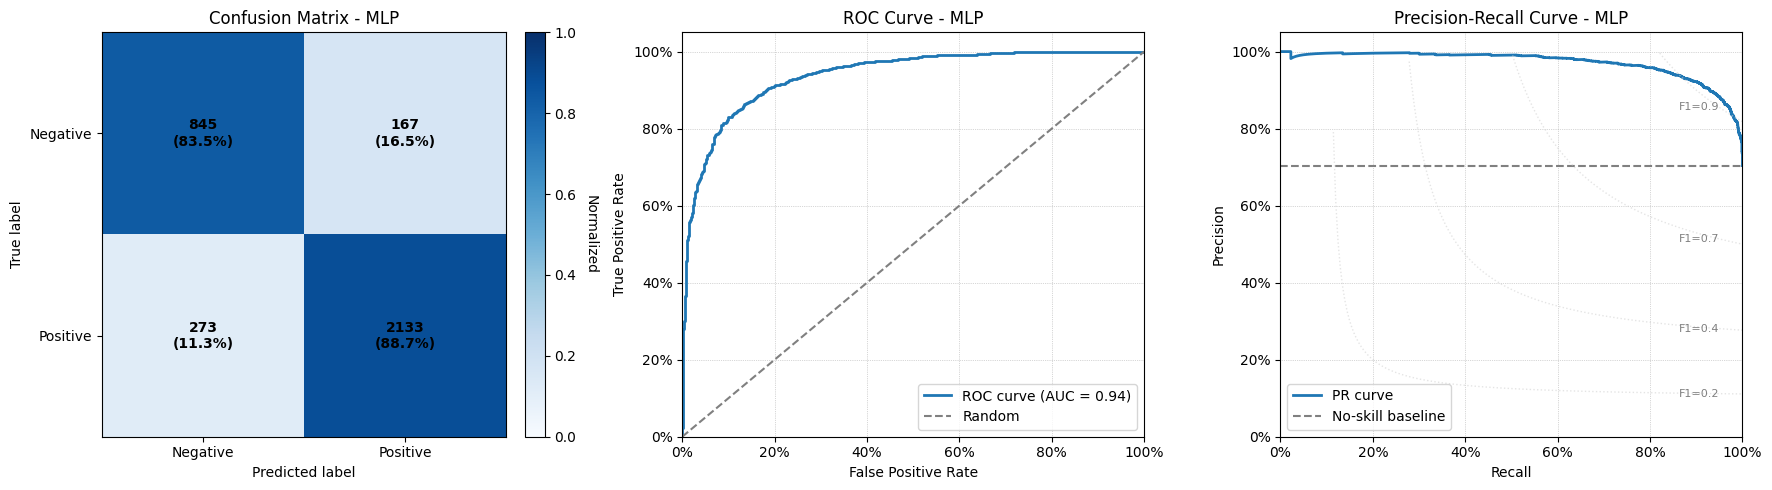


Bagging Evaluation Metrics
Accuracy : 0.863
Precision: 0.924
Recall   : 0.878
F1-score : 0.900
ROC AUC  : 0.931
Brier score: 0.0971

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1012
           1       0.92      0.88      0.90      2406

    accuracy                           0.86      3418
   macro avg       0.83      0.85      0.84      3418
weighted avg       0.87      0.86      0.87      3418

----------------------------------------------------------------------------------------------------


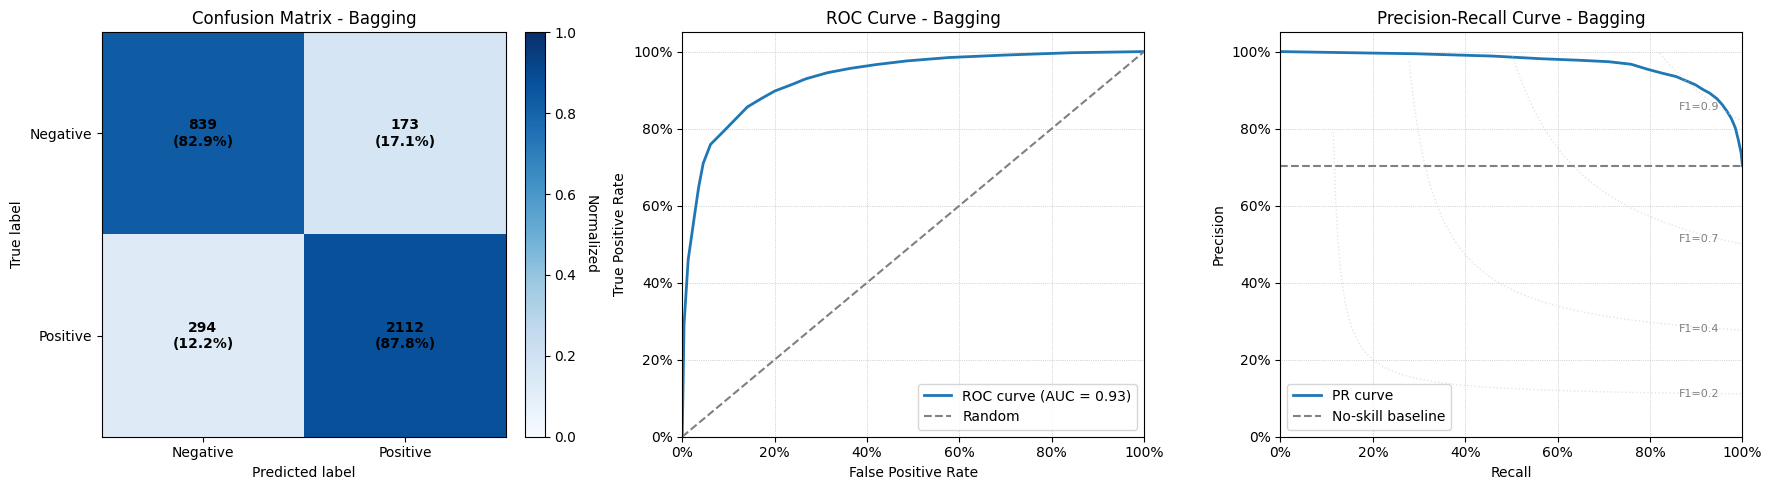


Stacking Evaluation Metrics
Accuracy : 0.857
Precision: 0.918
Recall   : 0.874
F1-score : 0.896
ROC AUC  : 0.917
Brier score: 0.1068

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1012
           1       0.92      0.87      0.90      2406

    accuracy                           0.86      3418
   macro avg       0.82      0.84      0.83      3418
weighted avg       0.86      0.86      0.86      3418

----------------------------------------------------------------------------------------------------


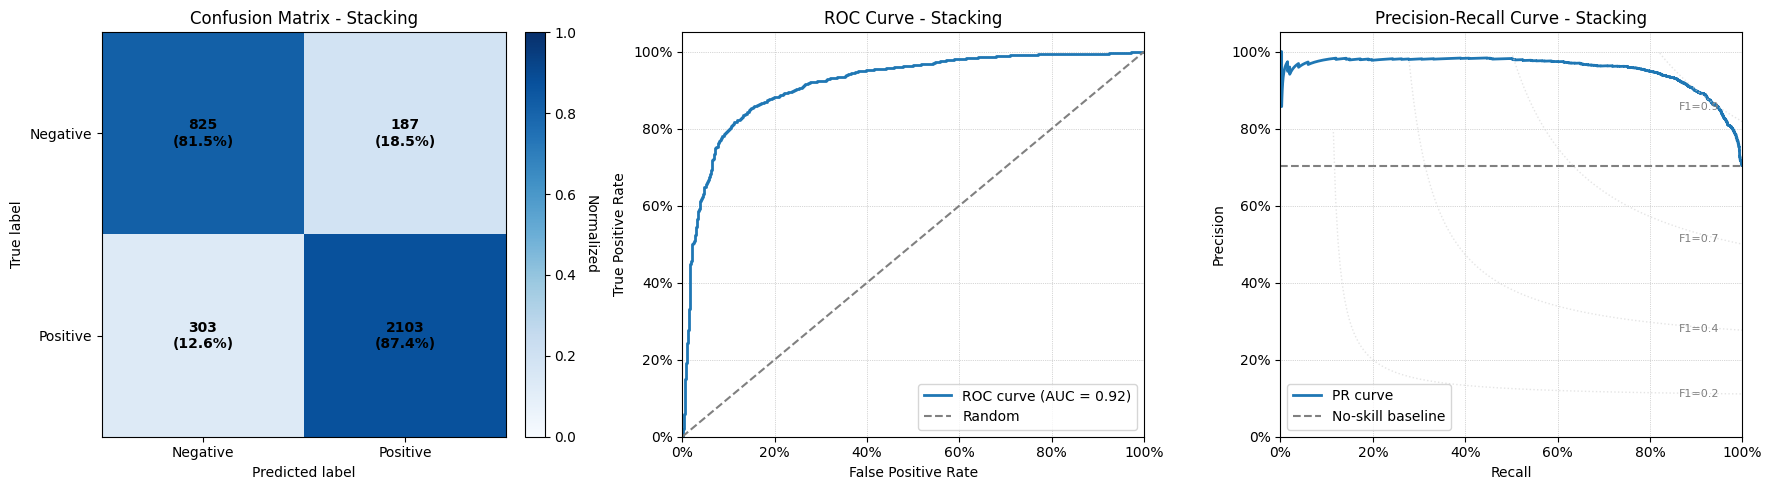


XGB Evaluation Metrics
Accuracy : 0.886
Precision: 0.931
Recall   : 0.905
F1-score : 0.918
ROC AUC  : 0.949
Brier score: 0.0855

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1012
           1       0.93      0.90      0.92      2406

    accuracy                           0.89      3418
   macro avg       0.86      0.87      0.87      3418
weighted avg       0.89      0.89      0.89      3418

----------------------------------------------------------------------------------------------------


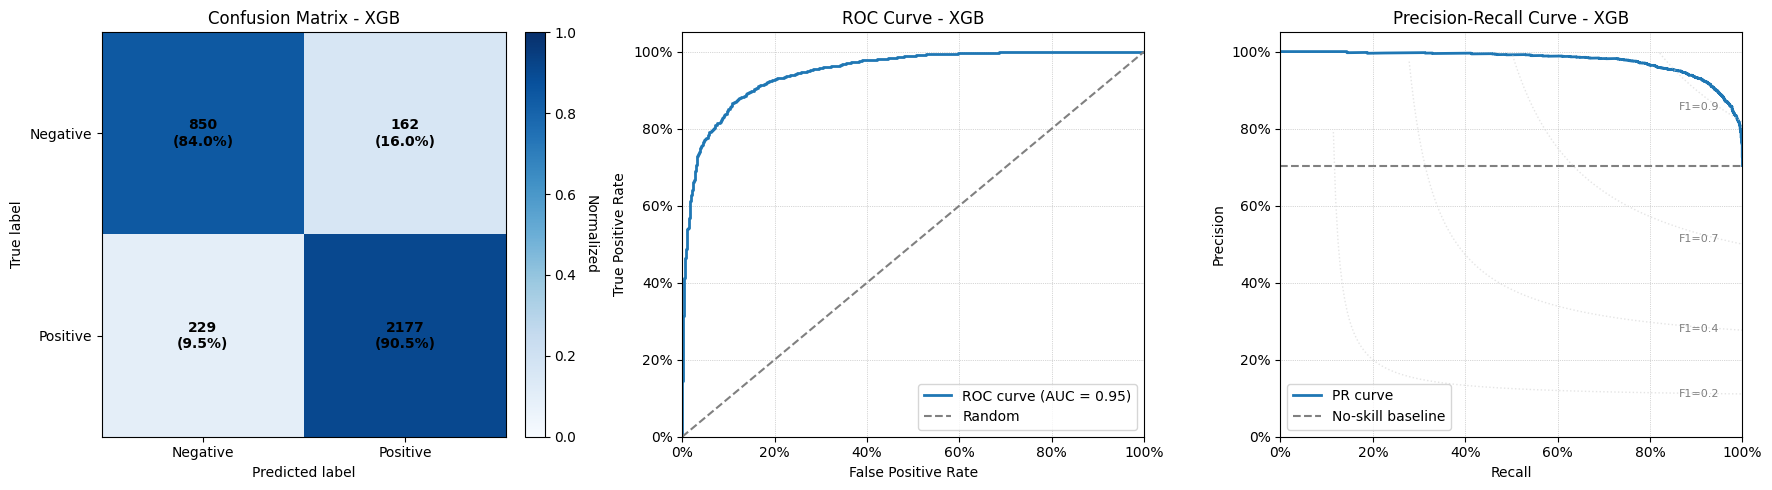


LGBM Evaluation Metrics
Accuracy : 0.885
Precision: 0.934
Recall   : 0.901
F1-score : 0.917
ROC AUC  : 0.950
Brier score: 0.0870

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1012
           1       0.93      0.90      0.92      2406

    accuracy                           0.89      3418
   macro avg       0.86      0.87      0.87      3418
weighted avg       0.89      0.89      0.89      3418

----------------------------------------------------------------------------------------------------


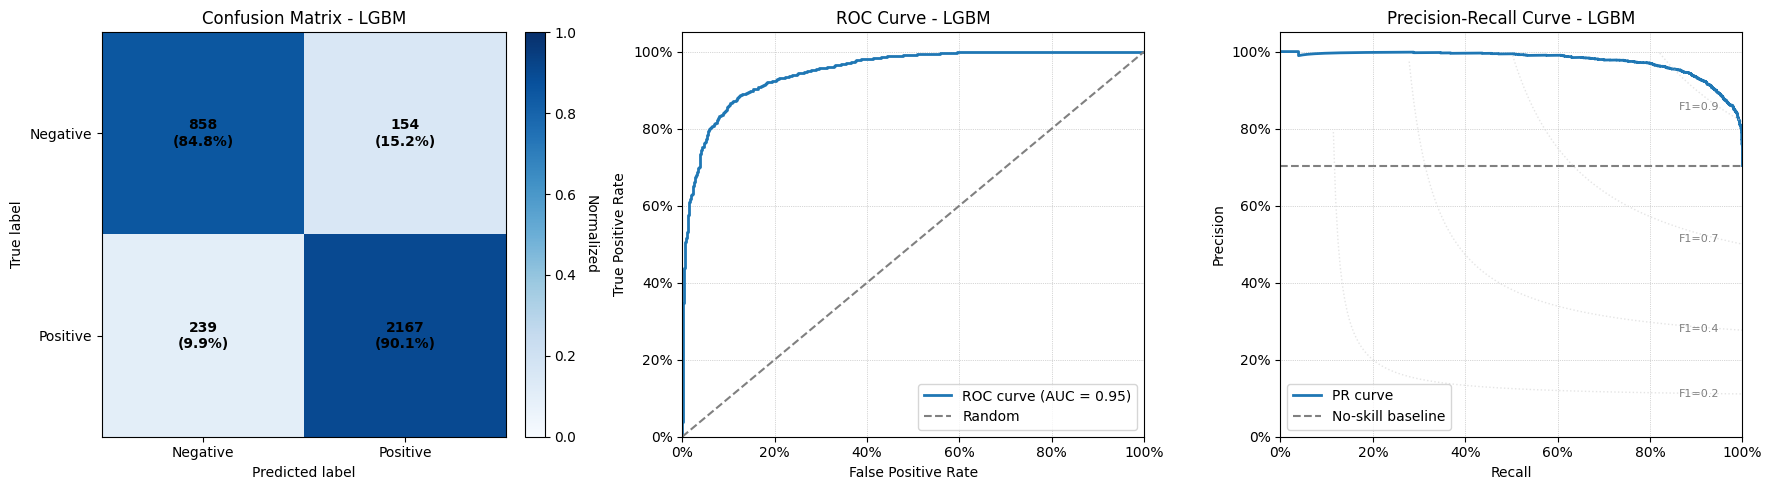

In [ ]:
y_pred_mlp = final_mlp_model.predict(X_test_scaled)
y_pred_bagging = final_bagging_model.predict(X_test_scaled)
y_pred_stacking = final_stacking_model.predict(X_test_scaled)
y_pred_xgb = final_xgb_model.predict(X_test_scaled)
y_pred_lgbm = final_lgbm_model.predict(X_test_scaled)

y_proba_mlp = final_mlp_model.predict_proba(X_test_scaled)[:, 1]
y_proba_bagging = final_bagging_model.predict_proba(X_test_scaled)[:, 1]
y_proba_stacking = final_stacking_model.predict_proba(X_test_scaled)[:, 1]
y_proba_xgb = final_xgb_model.predict_proba(X_test_scaled)[:, 1]
y_proba_lgbm = final_lgbm_model.predict_proba(X_test_scaled)[:, 1]

def _plot_confusion_matrix(ax, cm, model_name):
    """Plot confusion matrix with counts and normalized percentages."""
    total = cm.sum()
    with np.errstate(all='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    ax.set_title(f'Confusion Matrix - {model_name}')
    tick_labels = ['Negative', 'Positive']
    ax.set_xticks([0, 1])
    ax.set_xticklabels(tick_labels)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(tick_labels)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # Annotate with counts and percentages
    fmt = 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            pct = cm_norm[i, j]
            text = f"{count}\n({pct:.1%})"
            ax.text(j, i, text, ha='center', va='center', color='black', fontsize=10, fontweight='bold')

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Normalized', rotation=270, labelpad=15)
    ax.grid(False)


def _plot_precision_recall_with_iso_f1(ax, y_true, y_score, model_name):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_score)
    # No-skill baseline: positive class prevalence
    positive_ratio = np.mean(y_true)

    ax.plot(recall_vals, precision_vals, label='PR curve', lw=2)
    ax.plot([0, 1], [positive_ratio, positive_ratio], linestyle='--', label='No-skill baseline', color='gray')
    # Iso-F1 curves
    f_scores = np.linspace(0.2, 0.9, 4)
    for f in f_scores:
        # precision = f * recall / (2 * recall - f)
        # avoid division by zero / invalid regions
        recall_iso = np.linspace(0.01, 1.0, 200)
        with np.errstate(divide='ignore', invalid='ignore'):
            precision_iso = (f * recall_iso) / (2 * recall_iso - f)
        precision_iso[precision_iso < 0] = np.nan
        precision_iso[precision_iso > 1] = np.nan
        ax.plot(recall_iso, precision_iso, color='lightgray', alpha=0.6, linestyle=':', linewidth=1)
        ax.text(0.95, (f * 0.95) / (2 * 0.95 - f), f'F1={f:.1f}',
                fontsize=8, color='gray', va='center', ha='right')

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.05)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.legend(loc='lower left')
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))


def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    # Core metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0.0)
    recall = recall_score(y_true, y_pred, zero_division=0.0)
    f1 = f1_score(y_true, y_pred, zero_division=0.0)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    brier = brier_score_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Print summary
    print(f"{model_name} Evaluation Metrics")
    print(f"Accuracy : {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall   : {recall:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC AUC  : {roc_auc:.3f}")
    print(f"Brier score: {brier:.4f}")
    print()
    print(classification_report(y_true, y_pred, zero_division=0.0))
    print("-" * 100)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    # Confusion matrix
    _plot_confusion_matrix(axes[0], cm, model_name)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    axes[1].plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], linestyle='--', label='Random', color='gray')
    axes[1].set_xlim(0.0, 1.0)
    axes[1].set_ylim(0.0, 1.05)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {model_name}')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, linestyle=':', linewidth=0.5)
    axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

    # Precision-Recall with iso-F1
    _plot_precision_recall_with_iso_f1(axes[2], y_true, y_pred_proba, model_name)

    plt.tight_layout()
    plt.show()
    print()


evaluate_model(y_test, y_pred_mlp, y_proba_mlp, "MLP")
evaluate_model(y_test, y_pred_bagging, y_proba_bagging, "Bagging")
evaluate_model(y_test, y_pred_stacking, y_proba_stacking, "Stacking")
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGB")
evaluate_model(y_test, y_pred_lgbm, y_proba_lgbm, "LGBM")

Conjunto de treino 2:

MLP Evaluation Metrics
Accuracy : 0.874
Precision: 0.923
Recall   : 0.896
F1-score : 0.909
ROC AUC  : 0.934
Brier score: 0.0920

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1012
           1       0.92      0.90      0.91      2406

    accuracy                           0.87      3418
   macro avg       0.85      0.86      0.85      3418
weighted avg       0.88      0.87      0.88      3418

----------------------------------------------------------------------------------------------------


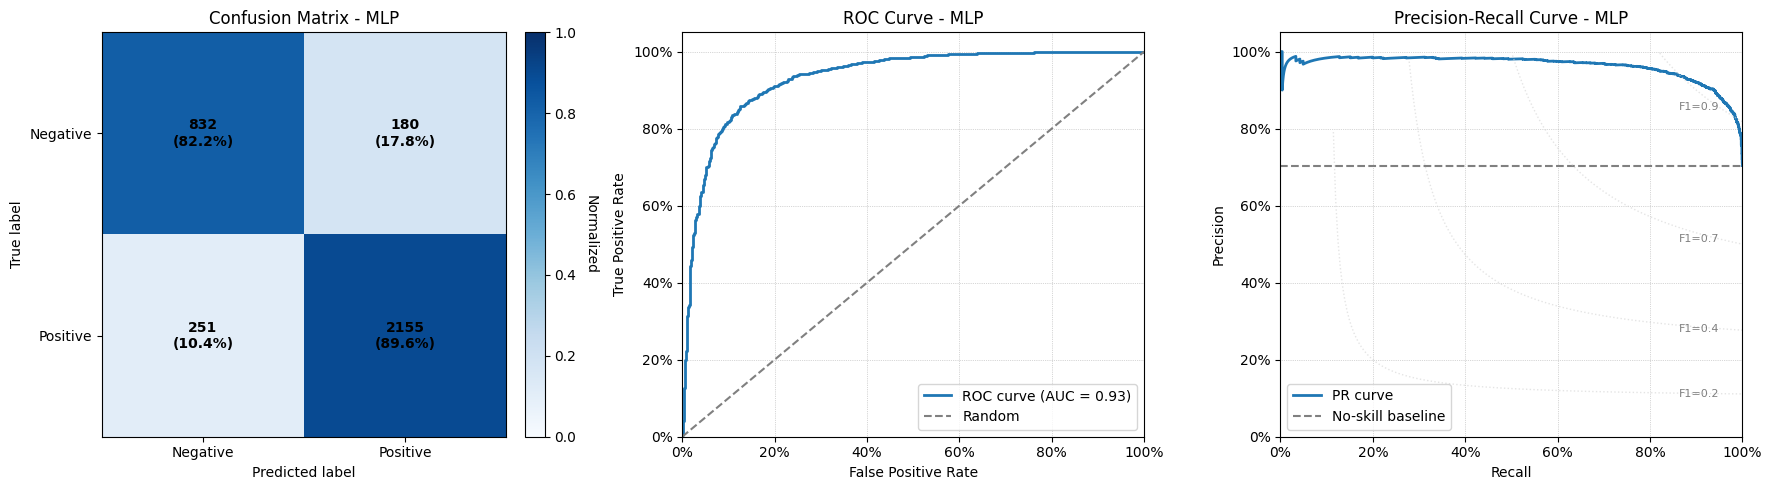


Bagging Evaluation Metrics
Accuracy : 0.862
Precision: 0.925
Recall   : 0.874
F1-score : 0.899
ROC AUC  : 0.929
Brier score: 0.0994

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1012
           1       0.92      0.87      0.90      2406

    accuracy                           0.86      3418
   macro avg       0.83      0.85      0.84      3418
weighted avg       0.87      0.86      0.86      3418

----------------------------------------------------------------------------------------------------


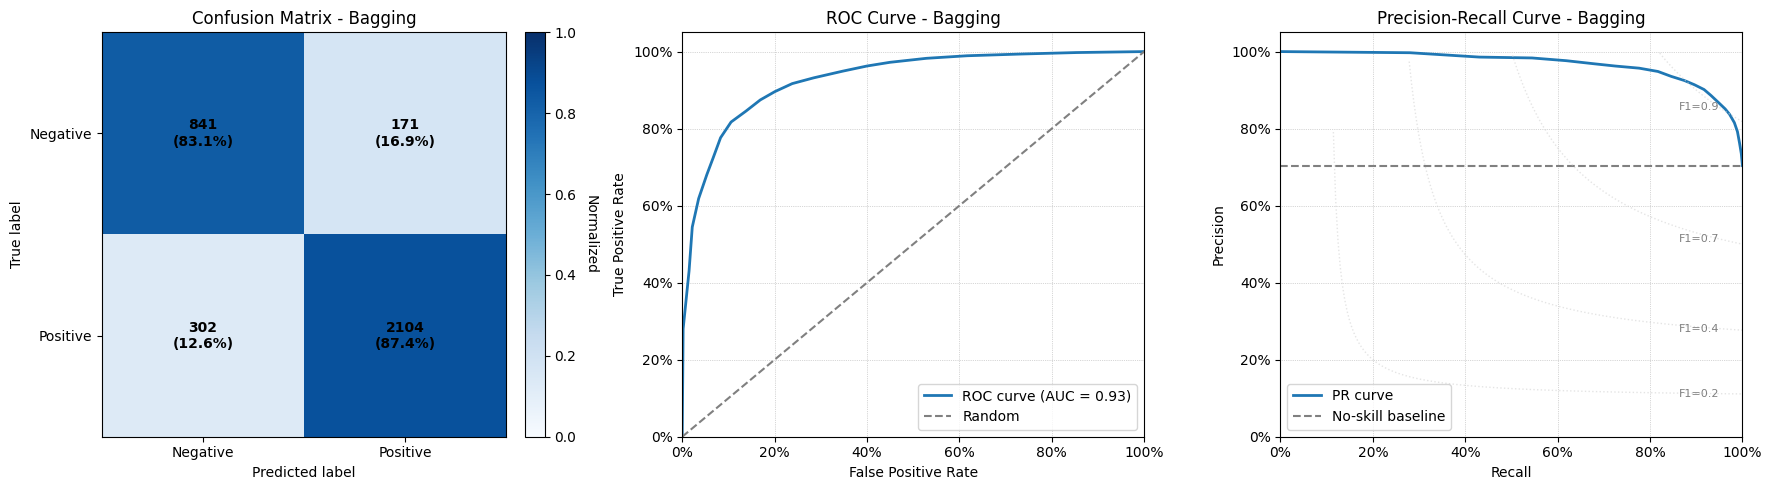


Stacking Evaluation Metrics
Accuracy : 0.851
Precision: 0.921
Recall   : 0.862
F1-score : 0.891
ROC AUC  : 0.920
Brier score: 0.1108

              precision    recall  f1-score   support

           0       0.72      0.82      0.77      1012
           1       0.92      0.86      0.89      2406

    accuracy                           0.85      3418
   macro avg       0.82      0.84      0.83      3418
weighted avg       0.86      0.85      0.85      3418

----------------------------------------------------------------------------------------------------


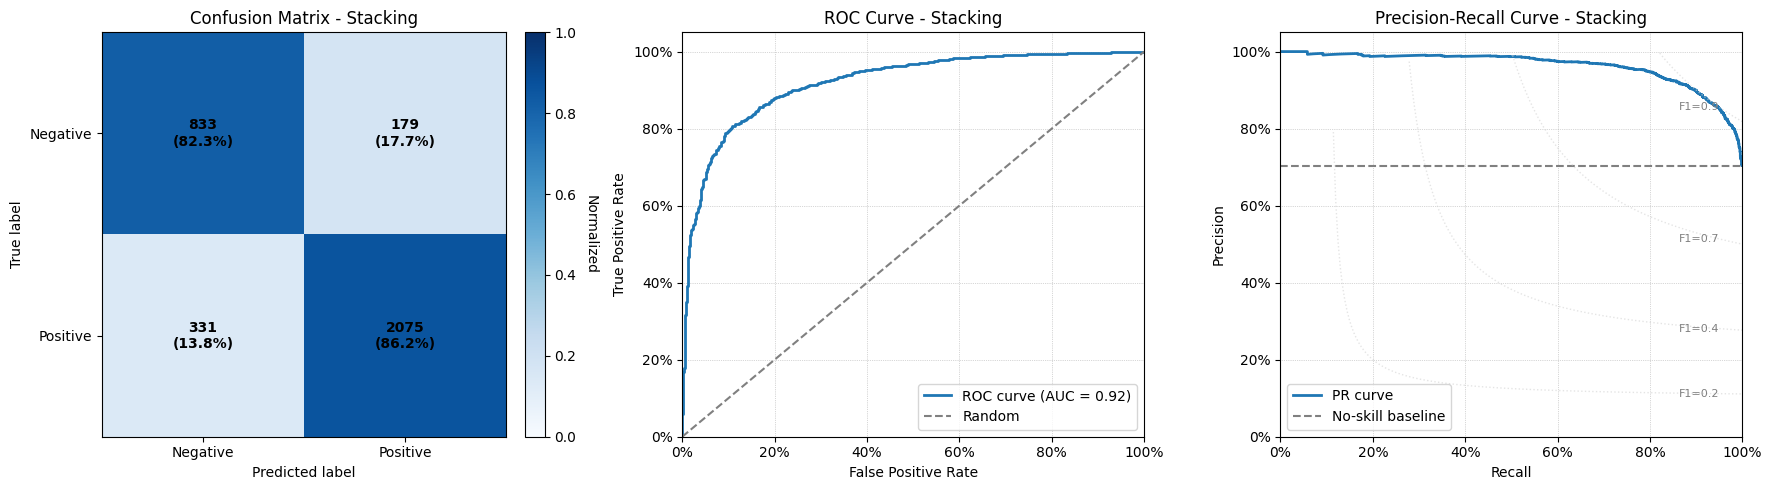


XGB Evaluation Metrics
Accuracy : 0.880
Precision: 0.933
Recall   : 0.894
F1-score : 0.913
ROC AUC  : 0.945
Brier score: 0.0894

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1012
           1       0.93      0.89      0.91      2406

    accuracy                           0.88      3418
   macro avg       0.85      0.87      0.86      3418
weighted avg       0.89      0.88      0.88      3418

----------------------------------------------------------------------------------------------------


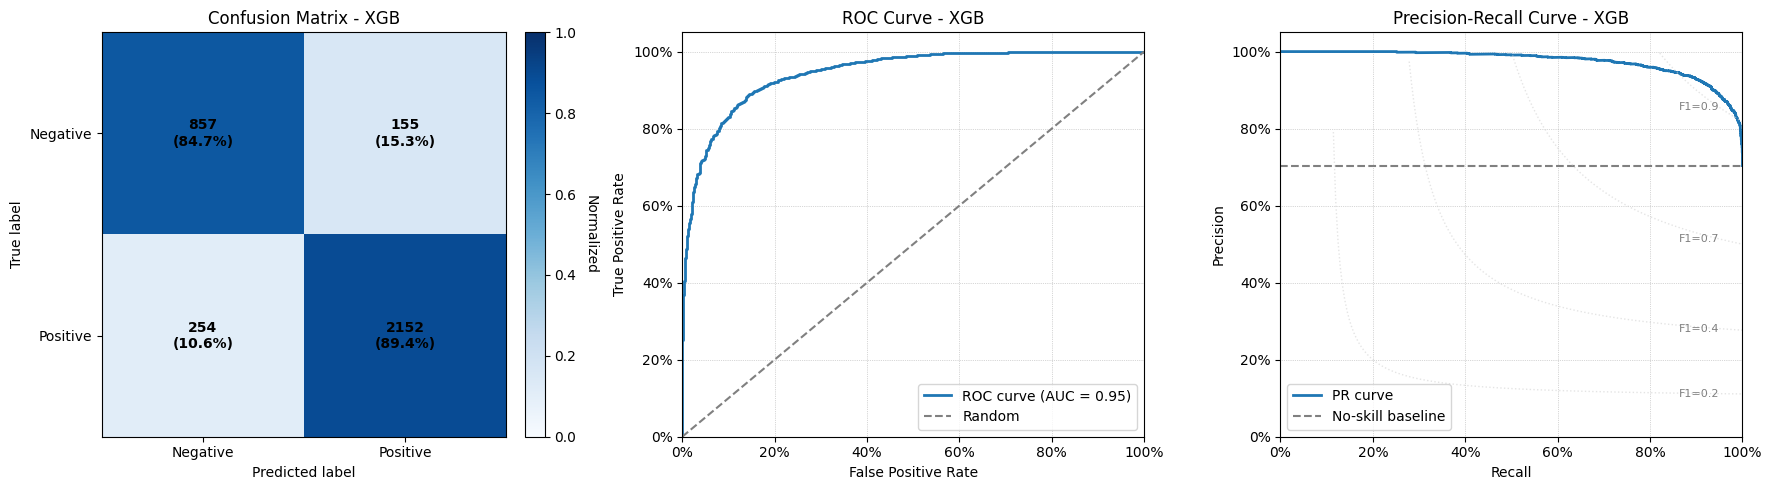


LGBM Evaluation Metrics
Accuracy : 0.885
Precision: 0.933
Recall   : 0.901
F1-score : 0.917
ROC AUC  : 0.947
Brier score: 0.0910

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1012
           1       0.93      0.90      0.92      2406

    accuracy                           0.89      3418
   macro avg       0.86      0.87      0.87      3418
weighted avg       0.89      0.89      0.89      3418

----------------------------------------------------------------------------------------------------


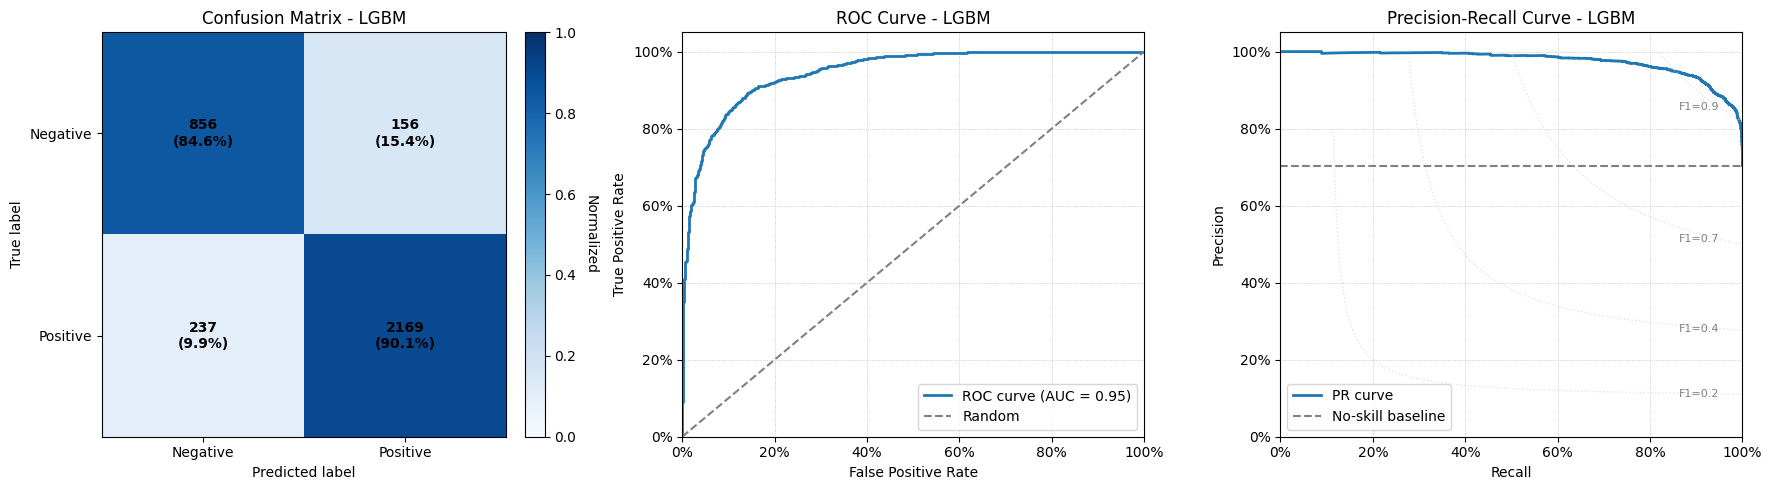

In [ ]:
y_pred_mlp_alt = final_mlp_model_alt.predict(X_test_filtered_no_corr_scaled)
y_pred_bagging_alt = final_bagging_model_alt.predict(X_test_filtered_no_corr_scaled)
y_pred_stacking_alt = final_stacking_model_alt.predict(X_test_filtered_no_corr_scaled)
y_pred_xgb_alt = final_xgb_model_alt.predict(X_test_filtered_no_corr_scaled)
y_pred_lgbm_alt = final_lgbm_model_alt.predict(X_test_filtered_no_corr_scaled)

y_proba_mlp_alt = final_mlp_model_alt.predict_proba(X_test_filtered_no_corr_scaled)[:, 1]
y_proba_bagging_alt = final_bagging_model_alt.predict_proba(X_test_filtered_no_corr_scaled)[:, 1]
y_proba_stacking_alt = final_stacking_model_alt.predict_proba(X_test_filtered_no_corr_scaled)[:, 1]
y_proba_xgb_alt = final_xgb_model_alt.predict_proba(X_test_filtered_no_corr_scaled)[:, 1]
y_proba_lgbm_alt = final_lgbm_model_alt.predict_proba(X_test_filtered_no_corr_scaled)[:, 1]

evaluate_model(y_test, y_pred_mlp_alt, y_proba_mlp_alt, "MLP")
evaluate_model(y_test, y_pred_bagging_alt, y_proba_bagging_alt, "Bagging")
evaluate_model(y_test, y_pred_stacking_alt, y_proba_stacking_alt, "Stacking")
evaluate_model(y_test, y_pred_xgb_alt, y_proba_xgb_alt, "XGB")
evaluate_model(y_test, y_pred_lgbm_alt, y_proba_lgbm_alt, "LGBM")

---

## Comparação e Análise

### Comparação de Desempenho


Conjunto de treino 1:

In [ ]:
results = {}

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
roc_auc_mlp = roc_auc_score(y_test, y_pred_mlp)
results['MLP'] = [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp, roc_auc_mlp]

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging, zero_division=0.0)
recall_bagging = recall_score(y_test, y_pred_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging)
roc_auc_bagging = roc_auc_score(y_test, y_pred_bagging)
results['Bagging'] = [accuracy_bagging, precision_bagging, recall_bagging, f1_bagging, roc_auc_bagging]

accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
roc_auc_stacking = roc_auc_score(y_test, y_pred_stacking)
results['Stacking'] = [accuracy_stacking, precision_stacking, recall_stacking, f1_stacking, roc_auc_stacking]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
results['XGB'] = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, roc_auc_xgb]

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_lgbm)
results['LGBM'] = [accuracy_lgbm, precision_lgbm, recall_lgbm, f1_lgbm, roc_auc_lgbm]

results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']).T

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']
min_val = results_df[metrics].min().min() - 0.05
max_val = results_df[metrics].max().max() + 0.05

def highlight_extremes(s):
    """Highlight max in green and min in red."""
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        'border: 3px solid green; box-shadow: 0 0 5px rgba(0, 128, 0, 0.5);' if is_max_val else
        'border: 3px solid red; box-shadow: 0 0 5px rgba(255, 0, 0, 0.5);' if is_min_val else
        ''
        for is_max_val, is_min_val in zip(is_max, is_min)
    ]

styled = (
    results_df
    .style
    .format({m: "{:.3f}" for m in metrics})
    .bar(subset=metrics, cmap='RdYlGn', width=100, vmin=min_val, vmax=max_val)
    .apply(highlight_extremes, subset=metrics, axis=0)
    .set_caption("Comparação de Performance dos Modelos")
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('padding', '4px')]},
        {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold')]},
    ])
)

styled

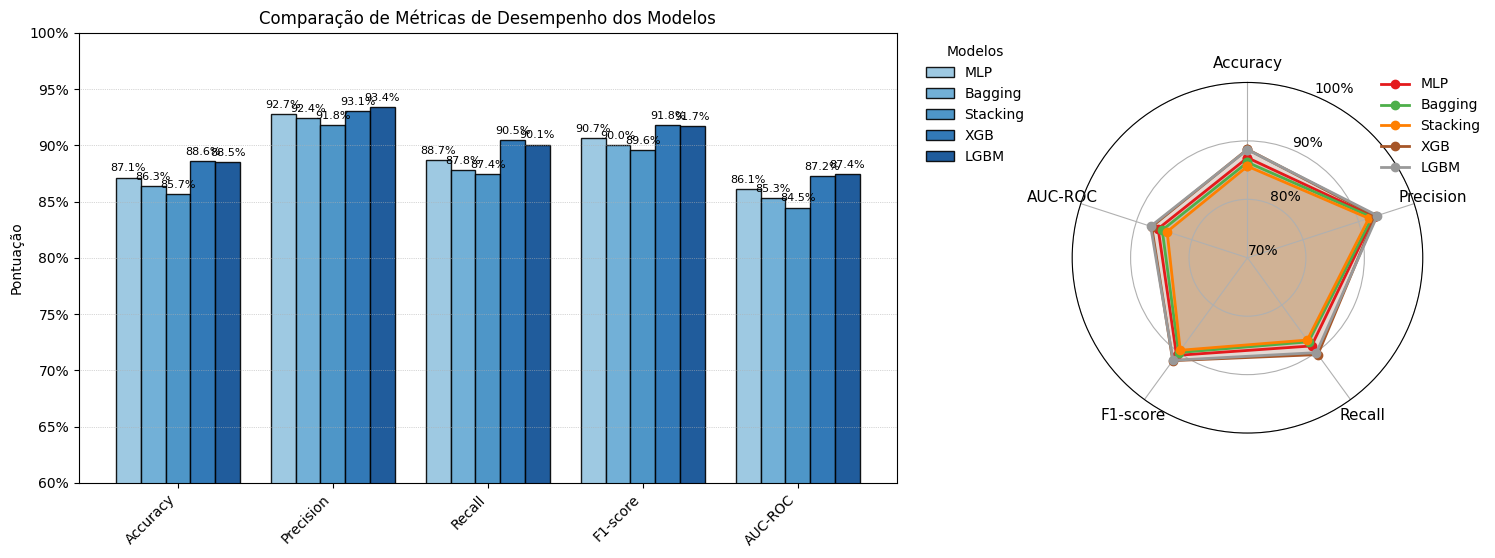

In [ ]:
results_df_T = results_df.T

n_models = results_df_T.shape[1]
metrics = results_df_T.index
x = np.arange(len(metrics))
bar_width = 0.8 / n_models

# Create figure with custom width ratios
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[0.7, 0.3], wspace=0.3)

# Bar chart (70% width)
ax1 = fig.add_subplot(gs[0])

colors_bar = plt.cm.Blues(np.linspace(0.4, 0.9, n_models))

for i, (model_name, color) in enumerate(zip(results_df_T.columns, colors_bar)):
    values = results_df_T[model_name].astype(float)
    positions = x - 0.4 + (i + 0.5) * bar_width
    bars = ax1.bar(positions, values, width=bar_width, label=model_name, edgecolor='black', alpha=0.9, color=color)

    for bar in bars:
        height = bar.get_height()
        ax1.annotate(
            f"{height:.1%}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=8
        )

ax1.set_title("Comparação de Métricas de Desempenho dos Modelos")
ax1.set_ylabel("Pontuação")
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.set_ylim(0.6, 1.0)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax1.legend(title="Modelos", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
ax1.grid(axis='y', linestyle=':', linewidth=0.5)

# Radar chart (30% width)
ax2 = fig.add_subplot(gs[1], polar=True)

labels = results_df.columns
n_metrics = len(labels)

angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
angles += angles[:1]

colors_radar = plt.cm.Set1(np.linspace(0, 1, len(results_df)))

for (model, color) in zip(results_df.index, colors_radar):
    values = results_df.loc[model].tolist()
    values += values[:1]
    ax2.plot(angles, values, label=model, color=color, linewidth=2, marker='o')
    ax2.fill(angles, values, color=color, alpha=0.15)

ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)

ax2.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=11)

ax2.set_ylim(0.7, 1.0)
radial_ticks = np.linspace(0.7, 1.0, 4)
ax2.set_yticks(radial_ticks)
ax2.set_yticklabels([f"{tick:.0%}" for tick in radial_ticks], fontsize=10)
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), frameon=False)

plt.subplots_adjust(left=0.08, right=0.92, top=0.9, bottom=0.15)
plt.show()

LightGBM e XGBoost se destacam como os modelos de melhor performance global, demonstrando a eficácia dos algoritmos de gradient boosting para este problema específico. O LightGBM apresenta resultados ligeiramente superiores ao XGBoost na maioria das métricas, com precision de 93.4% versus 93.1%, e recall de 90.1% versus 90.5%, respectivamente.

MLP (Multi-Layer Perceptron) demonstra performance competitiva, ocupando uma posição intermediária sólida com métricas consistentes em todas as dimensões avaliadas. Sua accuracy de 87.1% e F1-score de 90.7% indicam que as redes neurais conseguiram capturar adequadamente os padrões não-lineares presentes nos dados, embora não tenham superado os algoritmos de boosting.

Os métodos de ensemble (Bagging e Stacking) apresentaram resultados inferiores aos demais. Stacking apresentou a menor performance entre todos os modelos testados, com accuracy de 85.7% e F1-score de 89.6%.

O gráfico radar confirma visualmente que XGBoost e LightGBM apresentam profiles mais equilibrados e expandidos em todas as dimensões. O MLP mostra um profile ligeiramente mais contraído mas ainda bem balanceado, enquanto Stacking e Bagging apresentam contrações mais evidentes, particularmente em accuracy e precision.

Conjunto de treino 2:

In [ ]:
results_alt = {}

accuracy_mlp_alt = accuracy_score(y_test, y_pred_mlp_alt)
precision_mlp_alt = precision_score(y_test, y_pred_mlp_alt)
recall_mlp_alt = recall_score(y_test, y_pred_mlp_alt)
f1_mlp_alt = f1_score(y_test, y_pred_mlp_alt)
roc_auc_mlp_alt = roc_auc_score(y_test, y_pred_mlp_alt)
results_alt['MLP'] = [accuracy_mlp_alt, precision_mlp_alt, recall_mlp_alt, f1_mlp_alt, roc_auc_mlp_alt]

accuracy_bagging_alt = accuracy_score(y_test, y_pred_bagging_alt)
precision_bagging_alt = precision_score(y_test, y_pred_bagging_alt, zero_division=0.0)
recall_bagging_alt = recall_score(y_test, y_pred_bagging_alt)
f1_bagging_alt = f1_score(y_test, y_pred_bagging_alt)
roc_auc_bagging_alt = roc_auc_score(y_test, y_pred_bagging_alt)
results_alt['Bagging'] = [accuracy_bagging_alt, precision_bagging_alt, recall_bagging_alt, f1_bagging_alt, roc_auc_bagging_alt]

accuracy_stacking_alt = accuracy_score(y_test, y_pred_stacking_alt)
precision_stacking_alt = precision_score(y_test, y_pred_stacking_alt)
recall_stacking_alt = recall_score(y_test, y_pred_stacking_alt)
f1_stacking_alt = f1_score(y_test, y_pred_stacking_alt)
roc_auc_stacking_alt = roc_auc_score(y_test, y_pred_stacking_alt)
results_alt['Stacking'] = [accuracy_stacking_alt, precision_stacking_alt, recall_stacking_alt, f1_stacking_alt, roc_auc_stacking_alt]

accuracy_xgb_alt = accuracy_score(y_test, y_pred_xgb_alt)
precision_xgb_alt = precision_score(y_test, y_pred_xgb_alt)
recall_xgb_alt = recall_score(y_test, y_pred_xgb_alt)
f1_xgb_alt = f1_score(y_test, y_pred_xgb_alt)
roc_auc_xgb_alt = roc_auc_score(y_test, y_pred_xgb_alt)
results_alt['XGB'] = [accuracy_xgb_alt, precision_xgb_alt, recall_xgb_alt, f1_xgb_alt, roc_auc_xgb_alt]

accuracy_lgbm_alt = accuracy_score(y_test, y_pred_lgbm_alt)
precision_lgbm_alt = precision_score(y_test, y_pred_lgbm_alt)
recall_lgbm_alt = recall_score(y_test, y_pred_lgbm_alt)
f1_lgbm_alt = f1_score(y_test, y_pred_lgbm_alt)
roc_auc_lgbm_alt = roc_auc_score(y_test, y_pred_lgbm_alt)
results_alt['LGBM'] = [accuracy_lgbm_alt, precision_lgbm_alt, recall_lgbm_alt, f1_lgbm_alt, roc_auc_lgbm_alt]


results_alt_df = pd.DataFrame(results_alt, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']).T

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']
min_val = results_alt_df[metrics].min().min() - 0.05
max_val = results_alt_df[metrics].max().max() + 0.05

def highlight_extremes(s):
    """Highlight max in green and min in red."""
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        'border: 3px solid green; box-shadow: 0 0 5px rgba(0, 128, 0, 0.5);' if is_max_val else
        'border: 3px solid red; box-shadow: 0 0 5px rgba(255, 0, 0, 0.5);' if is_min_val else
        ''
        for is_max_val, is_min_val in zip(is_max, is_min)
    ]

styled = (
    results_alt_df
    .style
    .format({m: "{:.3f}" for m in metrics})
    .bar(subset=metrics, cmap='RdYlGn', width=100, vmin=min_val, vmax=max_val)
    .apply(highlight_extremes, subset=metrics, axis=0)
    .set_caption("Comparação de Performance dos Modelos")
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('padding', '4px')]},
        {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold')]},
    ])
)

styled

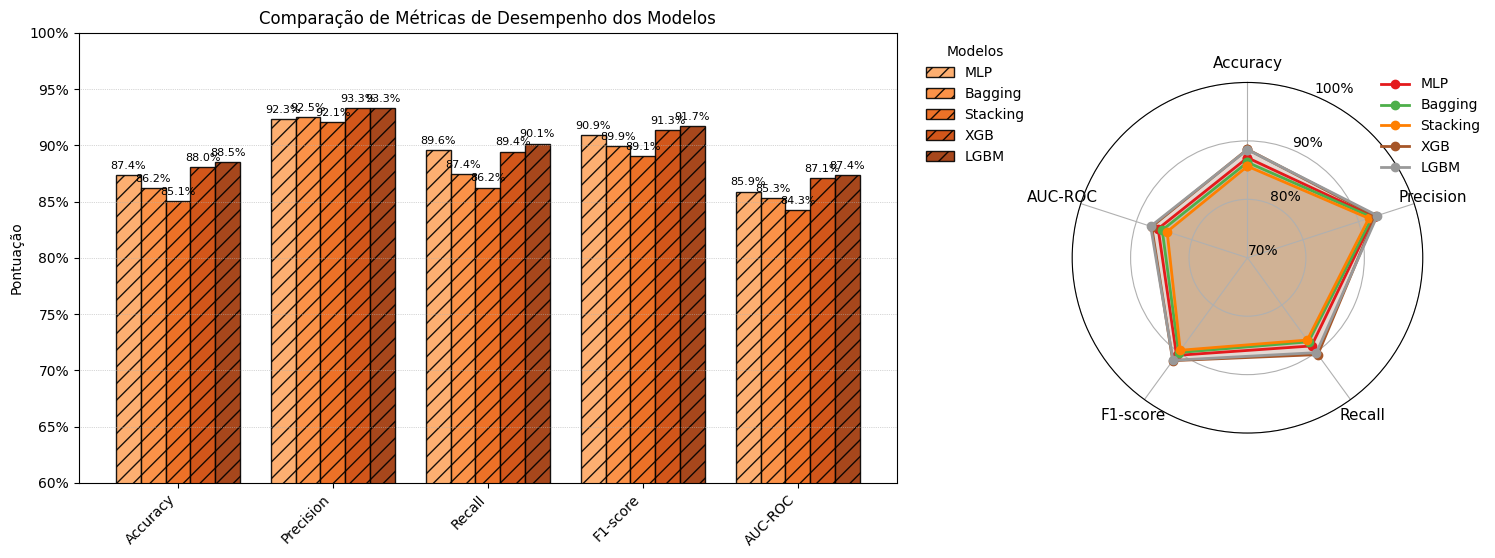

In [ ]:
results_alt_df_T = results_alt_df.T

n_models = results_alt_df_T.shape[1]
metrics = results_alt_df_T.index
x = np.arange(len(metrics))
bar_width = 0.8 / n_models

# Create figure with custom width ratios
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[0.7, 0.3], wspace=0.3)

# Bar chart (70% width)
ax1 = fig.add_subplot(gs[0])

colors_bar = plt.cm.Oranges(np.linspace(0.4, 0.9, n_models))

for i, (model_name, color) in enumerate(zip(results_alt_df_T.columns, colors_bar)):
    values = results_alt_df_T[model_name].astype(float)
    positions = x - 0.4 + (i + 0.5) * bar_width
    bars = ax1.bar(positions, values, width=bar_width, label=model_name, edgecolor='black', hatch='//', alpha=0.9, color=color)

    for bar in bars:
        height = bar.get_height()
        ax1.annotate(
            f"{height:.1%}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=8
        )

ax1.set_title("Comparação de Métricas de Desempenho dos Modelos")
ax1.set_ylabel("Pontuação")
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.set_ylim(0.6, 1.0)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax1.legend(title="Modelos", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
ax1.grid(axis='y', linestyle=':', linewidth=0.5)

# Radar chart (30% width)
ax2 = fig.add_subplot(gs[1], polar=True)

labels = results_df.columns
n_metrics = len(labels)

angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
angles += angles[:1]

colors_radar = plt.cm.Set1(np.linspace(0, 1, len(results_df)))

for (model, color) in zip(results_df.index, colors_radar):
    values = results_df.loc[model].tolist()
    values += values[:1]
    ax2.plot(angles, values, label=model, color=color, linewidth=2, marker='o')
    ax2.fill(angles, values, color=color, alpha=0.15)

ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)

ax2.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=11)

ax2.set_ylim(0.7, 1.0)
radial_ticks = np.linspace(0.7, 1.0, 4)
ax2.set_yticks(radial_ticks)
ax2.set_yticklabels([f"{tick:.0%}" for tick in radial_ticks], fontsize=10)
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), frameon=False)

plt.subplots_adjust(left=0.08, right=0.92, top=0.9, bottom=0.15)
plt.show()

Os resultados obtidos com o segundo conjunto de dados - que inclui normalização, tratamento de correlação e remoção de outliers - revelam padrões interessantes e algumas mudanças significativas na hierarquia de performance dos modelos quando comparados ao conjunto original.

LightGBM mantém sua posição de liderança, apresentando resultados consistentemente superiores com accuracy de 88.5%, precision de 93.3%, recall de 90.1% e F1-score de 91.7%. Curiosamente, suas métricas permanecem praticamente inalteradas em relação ao conjunto anterior, sugerindo que este algoritmo possui robustez natural aos outliers e correlações, provavelmente devido aos seus mecanismos internos de arquitetura.

XGBoost mantém a segunda posição, mas com uma ligeira redução na accuracy (88.0% vs 88.6% anterior) e recall (89.4% vs 90.5% anterior), embora sua precision tenha se mantido alta em 93.3%. Esta pequena degradação pode indicar que algumas informações úteis foram perdidas durante o pré-processamento mais agressivo, ou que o algoritmo se beneficiava de alguns dos outliers removidos para capturar padrões específicos.

MLP apresentou uma melhoria, com accuracy aumentando para 87.4% (vs 87.1% anterior) e recall melhorando significativamente para 89.6% (vs 88.7% anterior). Este resultado é particularmente interessante pois demonstra que as redes neurais se beneficiaram substancialmente do pré-processamento

Bagging apresentou resultados ligeiramente inferiores comparado ao conjunto anterior, com accuracy de 86.2% (vs 86.3%) e F1-score de 89.9% (vs 90.0%).

Stacking continuou apresentando a menor performance entre todos os modelos, com accuracy de 85.1% e F1-score de 89.1%. Interessantemente, houve uma ligeira melhoria em relação ao conjunto anterior (85.7% accuracy), mas ainda assim permanece como o modelo menos efetivo.

---

### Overfitting vs. underfitting


Conjunto de treino 1:


📊 MLP:
   Training F1: 0.8964
   Test F1:     0.9065
   Gap:         -0.0101 (-1.13%)
   Status:      🟢 Well Generalized

📊 BAGGING:
   Training F1: 1.0000
   Test F1:     0.9004
   Gap:         0.0996 (9.96%)
   Status:      🟠 Moderate Overfitting

📊 STACKING:
   Training F1: 0.9591
   Test F1:     0.8957
   Gap:         0.0635 (6.62%)
   Status:      🟠 Moderate Overfitting

📊 XGB:
   Training F1: 0.9916
   Test F1:     0.9176
   Gap:         0.0740 (7.46%)
   Status:      🟠 Moderate Overfitting

📊 LGBM:
   Training F1: 0.9999
   Test F1:     0.9169
   Gap:         0.0831 (8.31%)
   Status:      🟠 Moderate Overfitting


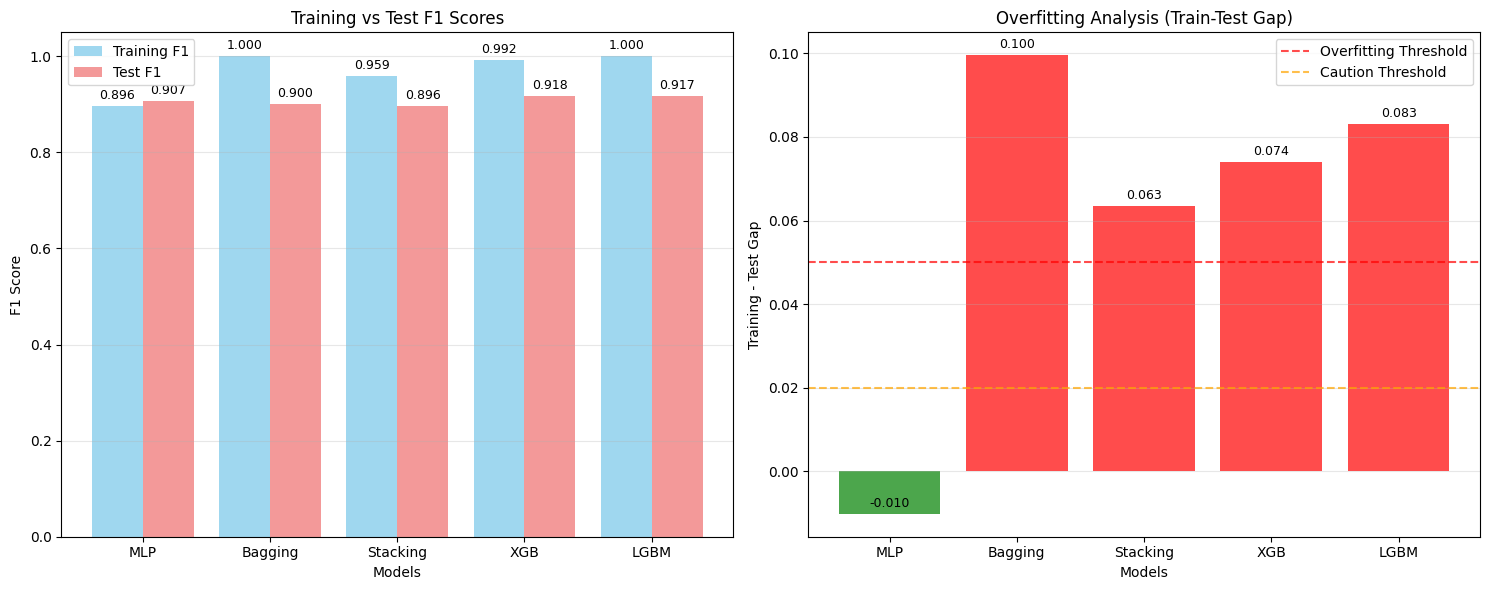

Best Test Performance: XGB (0.9176)
Highest Overfitting Risk: Bagging (Gap: 0.0996)
Best Generalization: MLP (Gap: -0.0101)


In [ ]:
# Define model search objects for cleaner code
search_objects = {
    'MLP': mlp_random_search_cv,
    'Bagging': ensemble_bagging_random_search_cv,
    'Stacking': stacking_random_search_cv,
    'XGB': xgb_random_search_cv,
    'LGBM': lgbm_random_search_cv
}

# Extract training scores more efficiently
train_f1_scores = {
    model: search_obj.cv_results_['mean_train_score'][search_obj.best_index_]
    for model, search_obj in search_objects.items()
}

# Test scores (assuming these variables exist from your previous code)
test_f1_scores = {
    'MLP': f1_mlp,
    'Bagging': f1_bagging,
    'Stacking': f1_stacking,
    'XGB': f1_xgb,
    'LGBM': f1_lgbm
}

# Create comprehensive analysis DataFrame
analysis_df = pd.DataFrame({
    'Training F1': train_f1_scores,
    'Test F1': test_f1_scores
})

analysis_df['Difference'] = analysis_df['Training F1'] - analysis_df['Test F1']
analysis_df['Gap %'] = (analysis_df['Difference'] / analysis_df['Training F1']) * 100

# Improved classification logic
def classify_performance(row):
    train_score = row['Training F1']
    test_score = row['Test F1']
    difference = row['Difference']
    gap_pct = row['Gap %']

    if difference > 0.1:  # 10% absolute difference
        return "🔴 Severe Overfitting"
    elif difference > 0.05:  # 5% absolute difference
        return "🟠 Moderate Overfitting"
    elif train_score < 0.7 and test_score < 0.7:
        return "🔵 Underfitting"
    elif gap_pct > 15:  # 15% relative gap
        return "🟡 Mild Overfitting"
    else:
        return "🟢 Well Generalized"

analysis_df['Status'] = analysis_df.apply(classify_performance, axis=1)

for model in analysis_df.index:
    train_score = analysis_df.loc[model, 'Training F1']
    test_score = analysis_df.loc[model, 'Test F1']
    difference = analysis_df.loc[model, 'Difference']
    gap_pct = analysis_df.loc[model, 'Gap %']
    status = analysis_df.loc[model, 'Status']

    print(f"\n📊 {model.upper()}:")
    print(f"   Training F1: {train_score:.4f}")
    print(f"   Test F1:     {test_score:.4f}")
    print(f"   Gap:         {difference:.4f} ({gap_pct:.2f}%)")
    print(f"   Status:      {status}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
models = list(analysis_df.index)
x_pos = np.arange(len(models))

bars1 = ax1.bar(x_pos - 0.2, analysis_df['Training F1'], 0.4,
                label='Training F1', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x_pos + 0.2, analysis_df['Test F1'], 0.4,
                label='Test F1', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('F1 Score')
ax1.set_title('Training vs Test F1 Scores')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

colors = ['red' if diff > 0.05 else 'orange' if diff > 0.02 else 'green'
          for diff in analysis_df['Difference']]

bars3 = ax2.bar(models, analysis_df['Difference'], color=colors, alpha=0.7)
ax2.set_xlabel('Models')
ax2.set_ylabel('Training - Test Gap')
ax2.set_title('Overfitting Analysis (Train-Test Gap)')
ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
ax2.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Caution Threshold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

best_model = analysis_df['Test F1'].idxmax()
worst_gap = analysis_df['Difference'].idxmax()
best_generalization = analysis_df.loc[analysis_df['Difference'] <= 0.05, 'Test F1'].idxmax() if len(analysis_df[analysis_df['Difference'] <= 0.05]) > 0 else "None"

print()
print(f"Best Test Performance: {best_model} ({analysis_df.loc[best_model, 'Test F1']:.4f})")
print(f"Highest Overfitting Risk: {worst_gap} (Gap: {analysis_df.loc[worst_gap, 'Difference']:.4f})")
if best_generalization != "None":
    print(f"Best Generalization: {best_generalization} (Gap: {analysis_df.loc[best_generalization, 'Difference']:.4f})")
else:
    print(f"Best Generalization: All models show some overfitting")

Os resultados apresentados fornecem insights fundamentais sobre a capacidade de generalização dos diferentes algoritmos testados, revelando padrões distintos de overfitting que têm implicações diretas para a aplicação prática destes modelos.

O Multi-Layer Perceptron demonstra o melhor comportamento de generalização entre todos os modelos testados, com um gap negativo de apenas -0.010 (-1.13%). Este resultado excepcional indica que o modelo na verdade performou ligeiramente melhor no conjunto de teste (F1: 0.9065) do que no treinamento.

Bagging, Stacking, XGBoost e LightGBM apresentam todos um overfitting moderado.

Conjunto de treino 2:

In [ ]:
train_f1_scores_alt = {
    'MLP': mlp_random_search_cv_alt.cv_results_['mean_train_score'][mlp_random_search_cv_alt.best_index_],
    'Bagging': ensemble_bagging_random_search_cv_alt.cv_results_['mean_train_score'][ensemble_bagging_random_search_cv_alt.best_index_],
    'Stacking': stacking_random_search_cv_alt.cv_results_['mean_train_score'][stacking_random_search_cv_alt.best_index_],
    'XGB': xgb_random_search_cv_alt.cv_results_['mean_train_score'][xgb_random_search_cv_alt.best_index_],
    'LGBM': lgbm_random_search_cv_alt.cv_results_['mean_train_score'][lgbm_random_search_cv_alt.best_index_]
}

test_f1_scores_alt = {
    'MLP': f1_mlp_alt,
    'Bagging': f1_bagging_alt,
    'Stacking': f1_stacking_alt,
    'XGB': f1_xgb_alt,
    'LGBM': f1_lgbm_alt
}

print("Training F1 Scores:")
for model, score in train_f1_scores_alt.items():
    print(f"{model}: {score:.4f}")

print("\nTest F1 Scores:")
for model, score in test_f1_scores_alt.items():
    print(f"{model}: {score:.4f}")

print("\nAnalysis of Overfitting vs. Underfitting:")
for model in train_f1_scores_alt.keys():
    train_score = train_f1_scores_alt[model]
    test_score = test_f1_scores_alt[model]
    difference = train_score - test_score

    print(f"\n{model}:")
    print(f"  Training F1-score: {train_score:.4f}")
    print(f"  Test F1-score: {test_score:.4f}")
    print(f"  Difference (Train - Test): {difference:.4f}")

    if difference > 0.05:
        print("  Conclusion: Potential Overfitting (Training score significantly higher than Test score)")
    elif train_score < 0.7:
         print("  Conclusion: Potential Underfitting (Low training and test scores)")
    else:
        print("  Conclusion: Performing Well (Similar training and test scores)")


Training F1 Scores:
MLP: 0.9014
Bagging: 1.0000
Stacking: 0.9526
XGB: 0.9931
LGBM: 1.0000

Test F1 Scores:
MLP: 0.9091
Bagging: 0.8990
Stacking: 0.8906
XGB: 0.9132
LGBM: 0.9169

Analysis of Overfitting vs. Underfitting:

MLP:
  Training F1-score: 0.9014
  Test F1-score: 0.9091
  Difference (Train - Test): -0.0077
  Conclusion: Performing Well (Similar training and test scores)

Bagging:
  Training F1-score: 1.0000
  Test F1-score: 0.8990
  Difference (Train - Test): 0.1010
  Conclusion: Potential Overfitting (Training score significantly higher than Test score)

Stacking:
  Training F1-score: 0.9526
  Test F1-score: 0.8906
  Difference (Train - Test): 0.0620
  Conclusion: Potential Overfitting (Training score significantly higher than Test score)

XGB:
  Training F1-score: 0.9931
  Test F1-score: 0.9132
  Difference (Train - Test): 0.0798
  Conclusion: Potential Overfitting (Training score significantly higher than Test score)

LGBM:
  Training F1-score: 1.0000
  Test F1-score: 0.9169



📊 MLP:
   Training F1: 0.9014
   Test F1:     0.9091
   Gap:         -0.0077 (-0.86%)
   Status:      🟢 Well Generalized

📊 BAGGING:
   Training F1: 1.0000
   Test F1:     0.8990
   Gap:         0.1010 (10.10%)
   Status:      🔴 Severe Overfitting

📊 STACKING:
   Training F1: 0.9526
   Test F1:     0.8906
   Gap:         0.0620 (6.51%)
   Status:      🟠 Moderate Overfitting

📊 XGB:
   Training F1: 0.9931
   Test F1:     0.9132
   Gap:         0.0798 (8.04%)
   Status:      🟠 Moderate Overfitting

📊 LGBM:
   Training F1: 1.0000
   Test F1:     0.9169
   Gap:         0.0831 (8.31%)
   Status:      🟠 Moderate Overfitting


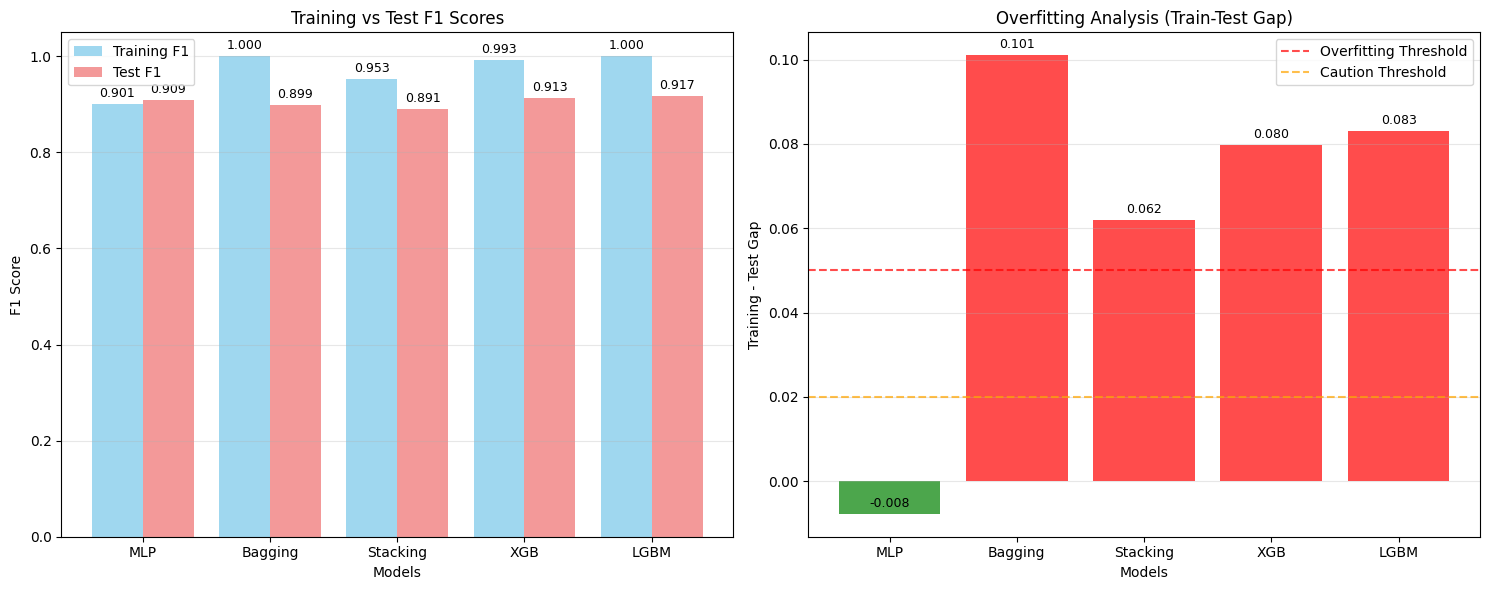


Best Test Performance: LGBM (0.9169)
Highest Overfitting Risk: Bagging (Gap: 0.1010)
Best Generalization: MLP (Gap: -0.0077)


In [ ]:
# Define model search objects for cleaner code
search_objects = {
    'MLP': mlp_random_search_cv_alt,
    'Bagging': ensemble_bagging_random_search_cv_alt,
    'Stacking': stacking_random_search_cv_alt,
    'XGB': xgb_random_search_cv_alt,
    'LGBM': lgbm_random_search_cv_alt
}

# Extract training scores more efficiently
train_f1_scores = {
    model: search_obj.cv_results_['mean_train_score'][search_obj.best_index_]
    for model, search_obj in search_objects.items()
}

# Test scores (assuming these variables exist from your previous code)
test_f1_scores = {
    'MLP': f1_mlp_alt,
    'Bagging': f1_bagging_alt,
    'Stacking': f1_stacking_alt,
    'XGB': f1_xgb_alt,
    'LGBM': f1_lgbm_alt
}

# Create comprehensive analysis DataFrame
analysis_df = pd.DataFrame({
    'Training F1': train_f1_scores,
    'Test F1': test_f1_scores
})

analysis_df['Difference'] = analysis_df['Training F1'] - analysis_df['Test F1']
analysis_df['Gap %'] = (analysis_df['Difference'] / analysis_df['Training F1']) * 100

# Improved classification logic
def classify_performance(row):
    train_score = row['Training F1']
    test_score = row['Test F1']
    difference = row['Difference']
    gap_pct = row['Gap %']

    if difference > 0.1:  # 10% absolute difference
        return "🔴 Severe Overfitting"
    elif difference > 0.05:  # 5% absolute difference
        return "🟠 Moderate Overfitting"
    elif train_score < 0.7 and test_score < 0.7:
        return "🔵 Underfitting"
    elif gap_pct > 15:  # 15% relative gap
        return "🟡 Mild Overfitting"
    else:
        return "🟢 Well Generalized"

analysis_df['Status'] = analysis_df.apply(classify_performance, axis=1)

for model in analysis_df.index:
    train_score = analysis_df.loc[model, 'Training F1']
    test_score = analysis_df.loc[model, 'Test F1']
    difference = analysis_df.loc[model, 'Difference']
    gap_pct = analysis_df.loc[model, 'Gap %']
    status = analysis_df.loc[model, 'Status']

    print(f"\n📊 {model.upper()}:")
    print(f"   Training F1: {train_score:.4f}")
    print(f"   Test F1:     {test_score:.4f}")
    print(f"   Gap:         {difference:.4f} ({gap_pct:.2f}%)")
    print(f"   Status:      {status}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
models = list(analysis_df.index)
x_pos = np.arange(len(models))

bars1 = ax1.bar(x_pos - 0.2, analysis_df['Training F1'], 0.4,
                label='Training F1', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x_pos + 0.2, analysis_df['Test F1'], 0.4,
                label='Test F1', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('F1 Score')
ax1.set_title('Training vs Test F1 Scores')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

colors = ['red' if diff > 0.05 else 'orange' if diff > 0.02 else 'green'
          for diff in analysis_df['Difference']]

bars3 = ax2.bar(models, analysis_df['Difference'], color=colors, alpha=0.7)
ax2.set_xlabel('Models')
ax2.set_ylabel('Training - Test Gap')
ax2.set_title('Overfitting Analysis (Train-Test Gap)')
ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
ax2.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Caution Threshold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

best_model = analysis_df['Test F1'].idxmax()
worst_gap = analysis_df['Difference'].idxmax()
best_generalization = analysis_df.loc[analysis_df['Difference'] <= 0.05, 'Test F1'].idxmax() if len(analysis_df[analysis_df['Difference'] <= 0.05]) > 0 else "None"

print()
print(f"Best Test Performance: {best_model} ({analysis_df.loc[best_model, 'Test F1']:.4f})")
print(f"Highest Overfitting Risk: {worst_gap} (Gap: {analysis_df.loc[worst_gap, 'Difference']:.4f})")
if best_generalization != "None":
    print(f"Best Generalization: {best_generalization} (Gap: {analysis_df.loc[best_generalization, 'Difference']:.4f})")
else:
    print(f"Best Generalization: All models show some overfitting")

Os resultados para esse conjunto foram semelhantes ao anterior.

---

### Melhores hiperparâmetros


Conjunto de treino 1:

In [ ]:
best_hyperparameters = {
    'MLP': mlp_random_search_cv.best_estimator_.get_params(),
    'Bagging': ensemble_bagging_random_search_cv.best_estimator_.get_params(),
    'Stacking': stacking_random_search_cv.best_estimator_.get_params(),
    'XGB': xgb_random_search_cv.best_estimator_.get_params(),
    'LGBM': lgbm_random_search_cv.best_estimator_.get_params()
}

print("Melhores Hiperparâmetros Encontrados:")
for model, params in best_hyperparameters.items():
    print(f"\n{model}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

Melhores Hiperparâmetros Encontrados:

MLP:
  activation: relu
  alpha: 0.001
  batch_size: auto
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: False
  epsilon: 1e-08
  hidden_layer_sizes: (64, 32)
  learning_rate: adaptive
  learning_rate_init: 0.001
  max_fun: 15000
  max_iter: 1000
  momentum: 0.9
  n_iter_no_change: 10
  nesterovs_momentum: True
  power_t: 0.5
  random_state: 9
  shuffle: True
  solver: adam
  tol: 0.0001
  validation_fraction: 0.1
  verbose: False
  warm_start: False

Bagging:
  bootstrap: False
  bootstrap_features: True
  estimator: None
  max_features: 1.0
  max_samples: 1.0
  n_estimators: 20
  n_jobs: None
  oob_score: False
  random_state: 9
  verbose: 0
  warm_start: False

Stacking:
  cv: 5
  estimators: [('dt', DecisionTreeClassifier(random_state=9)), ('knn', KNeighborsClassifier()), ('lr', LogisticRegression(random_state=9))]
  final_estimator__C: 1.0
  final_estimator__class_weight: None
  final_estimator__dual: False
  final_estimator__fit_intercept: 

Conjunto de treino 2:


In [ ]:
best_hyperparameters_alt = {
    'MLP': mlp_random_search_cv_alt.best_estimator_.get_params(),
    'Bagging': ensemble_bagging_random_search_cv_alt.best_estimator_.get_params(),
    'Stacking': stacking_random_search_cv_alt.best_estimator_.get_params(),
    'XGB': xgb_random_search_cv_alt.best_estimator_.get_params(),
    'LGBM': lgbm_random_search_cv_alt.best_estimator_.get_params()
}

print("Melhores Hiperparâmetros Encontrados:")
for model, params in best_hyperparameters_alt.items():
    print(f"\n{model}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

Melhores Hiperparâmetros Encontrados:

MLP:
  activation: relu
  alpha: 0.001
  batch_size: auto
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: False
  epsilon: 1e-08
  hidden_layer_sizes: (32,)
  learning_rate: adaptive
  learning_rate_init: 0.001
  max_fun: 15000
  max_iter: 1000
  momentum: 0.9
  n_iter_no_change: 10
  nesterovs_momentum: True
  power_t: 0.5
  random_state: 9
  shuffle: True
  solver: adam
  tol: 0.0001
  validation_fraction: 0.1
  verbose: False
  warm_start: False

Bagging:
  bootstrap: False
  bootstrap_features: True
  estimator: None
  max_features: 1.0
  max_samples: 1.0
  n_estimators: 20
  n_jobs: None
  oob_score: False
  random_state: 9
  verbose: 0
  warm_start: False

Stacking:
  cv: 5
  estimators: [('dt', DecisionTreeClassifier(random_state=9)), ('knn', KNeighborsClassifier()), ('lr', LogisticRegression(random_state=9))]
  final_estimator__C: 1.0
  final_estimator__class_weight: None
  final_estimator__dual: False
  final_estimator__fit_intercept: Tru

 - MLP: O melhor MLP utilizou arquitetura hidden_layer_sizes=(64, 32), activation='relu', solver='adam', learning_rate='adaptive', alpha=0.001.
A arquitetura de duas camadas ocultas (64→32 neurônios) cria um funil de informação que força a rede a aprender representações hierárquicas progressivamente mais abstratas, sendo ideal para capturar padrões complexos sem excessiva complexidade. A função de ativação relu é uma escolha robusta que evita o problema de gradientes desvanecentes e oferece eficiência computacional superior. O solver adam combina momentum adaptativo com taxas de aprendizado individualizadas para cada parâmetro, proporcionando convergência rápida e estável. A learning_rate='adaptive' permite ajuste automático da taxa quando a perda para de diminuir, evitando oscilações próximo ao mínimo e melhorando a convergência final. O parâmetro de regularização alpha=0.001 oferece um equilíbrio ideal entre capacidade de aprendizado e prevenção de overfitting.


- Bagging: O melhor Bagging utilizou n_estimators=20, bootstrap=False, bootstrap_features=True, max_features=1.0, max_samples=1.0.
A escolha de 20 estimadores representa um compromisso eficiente entre diversidade do ensemble e custo computacional. A configuração bootstrap=False com max_samples=1.0 significa que cada estimador base é treinado no conjunto completo de dados, maximizando a informação disponível para cada modelo individual. Contrastando, bootstrap_features=True introduz diversidade através da reamostragem de características, permitindo que cada estimador veja o mesmo conjunto de exemplos mas com diferentes perspectivas dimensionais. O uso de todas as features (max_features=1.0) combinado com bootstrap de características cria um equilíbrio interessante: máxima informação por estimador com diversidade suficiente para benefícios de ensemble.


- Stacking: O melhor Stacking utilizou cv=5, passthrough=True, estimadores base com configurações padrão (DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression)


- XGBoost: O melhor XGBoost utilizou n_estimators=200, max_depth=9, learning_rate=0.2, colsample_bytree=0.6, subsample=1.0, gamma=1, reg_lambda=1.
O número elevado de estimadores (200) combinado com uma taxa de aprendizado relativamente alta (0.2) indica que o modelo necessita de muitas iterações para convergir adequadamente, mas cada iteração contribui significativamente. A profundidade máxima de 9 permite árvores complexas capazes de capturar interações de alta ordem entre features. A amostragem de características colsample_bytree=0.6 introduz diversidade dimensional que melhora a generalização, enquanto subsample=1.0 mantém toda a informação de treinamento disponível. O parâmetro gamma=1 impõe um threshold mínimo para divisões, controlando a complexidade estrutural das árvores. A regularização L2 moderada (reg_lambda=1) sem regularização L1 (reg_alpha=0) sugere que o problema se beneficia de suavização de pesos sem necessidade de esparsidade.

- LightGBM: O melhor LightGBM utilizou n_estimators=200, max_depth=12, num_leaves=100, learning_rate=0.1, min_child_samples=10, colsample_bytree=1.0, subsample=1.0.
A configuração com 200 estimadores e taxa de aprendizado conservadora (0.1) seguindo a filosofia "aprender devagar mas aprender bem" do gradient boosting. A profundidade máxima de 12 com 100 folhas permite árvores altamente complexas, aproveitando a estratégia leaf-wise do LightGBM que cresce árvores de forma mais eficiente que algoritmos tradicionais. O parâmetro min_child_samples=10 oferece regularização estrutural moderada, prevenindo folhas com muito poucas amostras. O uso de todas as características e amostras (colsample_bytree=1.0, subsample=1.0) sugere que o algoritmo se beneficia de acesso completo aos dados, confiando em seus mecanismos internos de regularização para controlar overfitting.

### Comparação Entre Conjuntos

A visualização comparativa entre os conjuntos "Original" (apenas normalização) e "Filtered & No Corr" (normalização + remoção de outliers + tratamento de correlação) revela padrões distintos de resposta ao pré-processamento avançado, fornecendo insights valiosos sobre a sensibilidade de cada algoritmo às transformações de dados.

In [ ]:
combined_results_df = pd.concat([results_df, results_alt_df])
combined_results_df = combined_results_df.reset_index()
combined_results_df = combined_results_df.rename(columns={'index': 'Model'})
combined_results_df['Training Set'] = ['Original'] * len(results_df) + ['Filtered & No Corr'] * len(results_alt_df)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']

min_val = combined_results_df[metrics].min().min() - 0.05
max_val = combined_results_df[metrics].max().max() + 0.05

def highlight_extremes(s):
    """Highlight max in green and min in red."""
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        'border: 3px solid green; box-shadow: 0 0 5px rgba(0, 128, 0, 0.5);' if is_max_val else
        'border: 3px solid red; box-shadow: 0 0 5px rgba(255, 0, 0, 0.5);' if is_min_val else
        ''
        for is_max_val, is_min_val in zip(is_max, is_min)
    ]

styled = (
    combined_results_df
    .style
    .format({m: "{:.3f}" for m in metrics})
    .bar(subset=metrics, cmap='RdYlGn', width=100, vmin=min_val, vmax=max_val)
    .apply(highlight_extremes, subset=metrics, axis=0)
    .set_caption("Comparação de Métricas: Original vs Filtrado & Sem Correlação")
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('padding', '4px')]},
    ])
)

styled

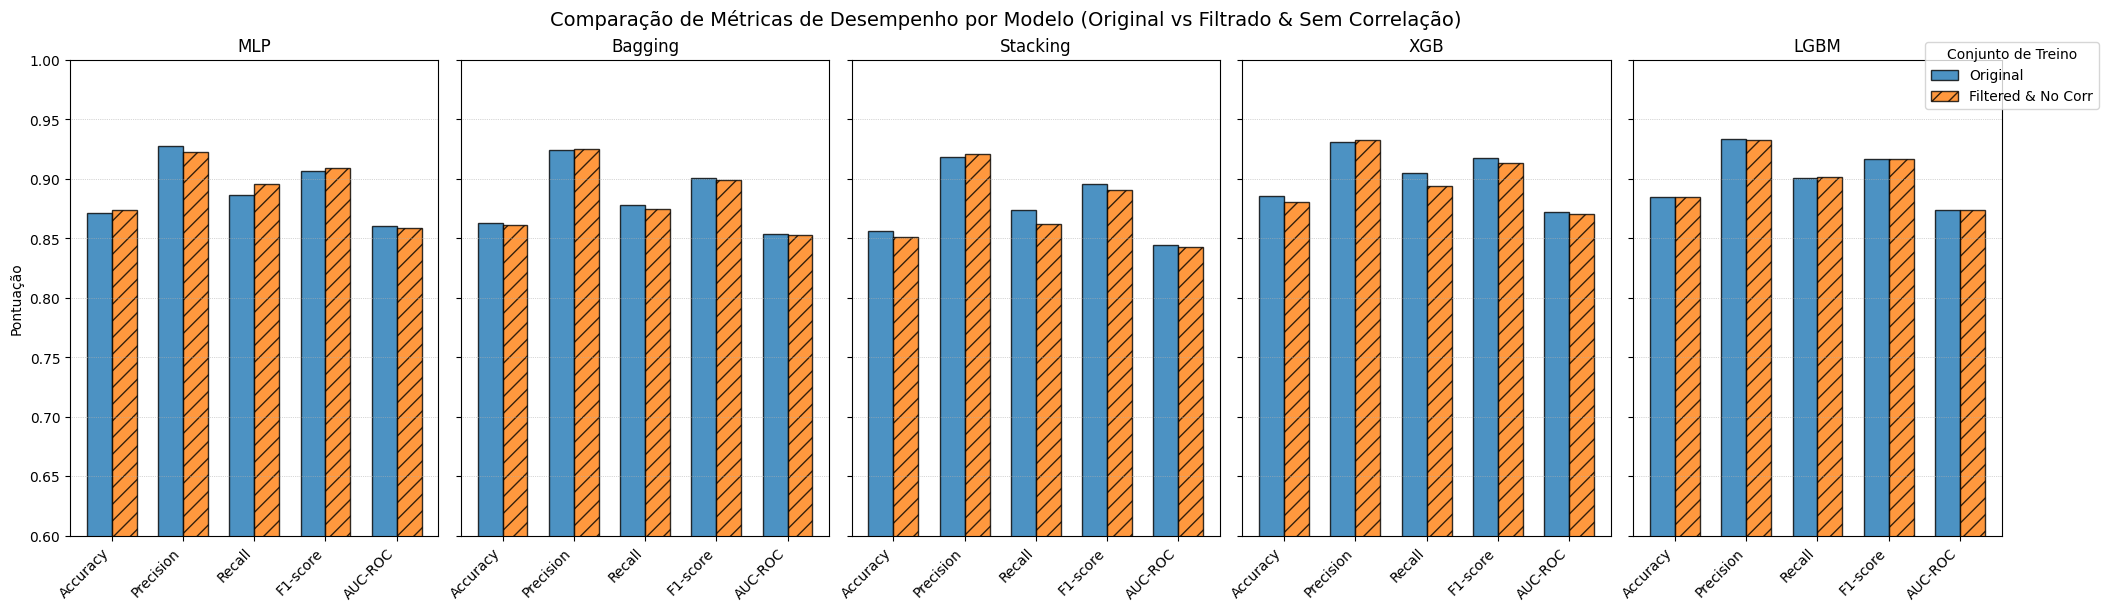

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']
n_metrics = len(metrics)
model_names = combined_results_df['Model'].unique()
n_models = len(model_names)

x = np.arange(n_metrics)
bar_width = 0.35

fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 6), sharey=True, constrained_layout=True)

color_orig = 'tab:blue'
color_filt = 'tab:orange'

for ax, model_name in zip(axes, model_names):
    try:
        original_scores = combined_results_df.loc[
            (combined_results_df['Model'] == model_name) &
            (combined_results_df['Training Set'] == 'Original'), metrics
        ].iloc[0].values
    except IndexError:
        original_scores = np.zeros(n_metrics)
    try:
        filtered_scores = combined_results_df.loc[
            (combined_results_df['Model'] == model_name) &
            (combined_results_df['Training Set'] == 'Filtered & No Corr'), metrics
        ].iloc[0].values
    except IndexError:
        filtered_scores = np.zeros(n_metrics)

    # Plot side-by-side bars
    ax.bar(x - bar_width / 2, original_scores, width=bar_width, label='Original', alpha=0.8, edgecolor='black', hatch=None, color=color_orig)
    ax.bar(x + bar_width / 2, filtered_scores, width=bar_width, label='Filtered & No Corr', alpha=0.8, edgecolor='black', hatch='//', color=color_filt)

    ax.set_title(model_name)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylim([0.6, 1.0])
    ax.set_ylabel("Pontuação" if ax is axes[0] else "")
    ax.grid(axis='y', linestyle=':', linewidth=0.5)

# Single legend for all
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, title="Conjunto de Treino", loc='upper right', bbox_to_anchor=(1.05, 0.95))

fig.suptitle("Comparação de Métricas de Desempenho por Modelo (Original vs Filtrado & Sem Correlação)", fontsize=14)
plt.show()

**MLP - Único Beneficiário Significativo:**
Apresenta melhorias consistentes, especialmente no recall (~0.896 → ~0.909). Redes neurais são naturalmente sensíveis a outliers e correlações, beneficiando-se da "limpeza" dos dados.

**Bagging e Stacking - Estabilidade Notável:**
Praticamente inalterados pelo pré-processamento. A diversidade inerente dos ensembles já oferece robustez natural contra outliers e correlações.

**XGBoost - Melhoria Seletiva:**
Ligeira melhoria na precision (~0.931 → ~0.933) com pequena redução no recall. O pré-processamento ajuda a reduzir falsos positivos.

**LightGBM - Robustez Total:**
Mudanças imperceptíveis em todas as métricas. Seus mecanismos internos já lidam efetivamente com outliers e correlações.

Padrões Observados:

- **Trade-off Precision vs Recall:** Pré-processamento avançado favorece ligeiramente precision sobre recall
- **F1-Score Estável:** Permanece consistente para todos os modelos, indicando benefício líquido limitado
- **AUC-ROC Inalterado:** Capacidade de discriminação entre classes não é afetada significativamente.

---

### Conclusões


Após uma análise abrangente dos resultados obtidos com a otimização de hiperparâmetros e comparação entre diferentes abordagens de machine learning, o XGBoost emergiu como o modelo superior para a classificação de preços imobiliários, alcançando um F1-score de 0.918 no conjunto de teste. Este resultado representa uma melhoria significativa em relação à análise do relatório anterior, onde o Random Forest havia sido considerado o melhor modelo com F1-score de aproximadamente 0.88.

O desempenho excepcional do XGBoost pode ser atribuído à sua capacidade de lidar eficientemente com características complexas dos dados imobiliários, combinando alta precisão (93.3%) com bom recall (89.4%). Esta combinação é particularmente valiosa no contexto imobiliário, onde tanto a identificação correta de propriedades subvalorizadas quanto a minimização de falsos positivos são cruciais para decisões de investimento bem-informadas. O LGBM apresentou performance muito próxima, com F1-score de 0.917, demonstrando que os algoritmos de gradient boosting são particularmente adequados para este tipo de problema.

Interessantemente, a análise revelou que a filtragem de features baseada em correlação, que inicialmente parecia uma estratégia promissora, não trouxe benefícios consistentes para todos os modelos. Enquanto alguns algoritmos como MLP e Bagging mostraram ligeira melhoria com a remoção de features correlacionadas, o XGBoost manteve performance estável independentemente da filtragem, demonstrando sua robustez intrínseca ao lidar com redundâncias nos dados.

Esta análise demonstra que, com a aplicação adequada de técnicas de machine learning e otimização cuidadosa de hiperparâmetros, é possível desenvolver ferramentas preditivas robustas e confiáveis para o mercado imobiliário, oferecendo valor significativo para diversos stakeholders do setor.

---